In [110]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py
import copy

sys.path.insert(0, '../../..')
import w2dyn.dmft.interaction as ia
import w2dyn.auxiliaries.compound_index as ci

sys.path.insert(0, '/home/josef/Programs/ed')
import ed.ed as ed

In [111]:
beta = 1.
u_value = 2.
impu = ed.ImpurityED(vk=[0.3], epsk=[0.5], beta=beta, mu=-0.1, u_value=u_value)
occ = impu.occ(0, 0)
hartree = occ * u_value

In [112]:
u_antisymm_1, u_antisymm_2, u_antisymm_both = ed.u_matrices(u_value)

We want to construct theta_0. (E.g. 0 = spin up, 1 = spin down)

We get a contribution from 4 terms:
* $[d_\downarrow^\dagger d_\uparrow d_\downarrow](\tau_1)\; [d_\uparrow^\dagger d_\downarrow^\dagger d_\downarrow](\tau_2)$ $\Rightarrow$ index 44, $U$ prefactor $U_{[\uparrow \downarrow]\downarrow\uparrow}\, U_{\uparrow\downarrow[\uparrow\downarrow]} = -U^2 / 4$
* $[d_\downarrow^\dagger d_\downarrow d_\uparrow](\tau_1)\; [d_\uparrow^\dagger d_\downarrow^\dagger d_\downarrow](\tau_2)$ $\Rightarrow$ index 52, $U$ prefactor $U_{[\uparrow \downarrow]\uparrow\downarrow}\, U_{\uparrow\downarrow[\uparrow\downarrow]} = +U^2 / 4$
* $[d_\downarrow^\dagger d_\uparrow d_\downarrow](\tau_1)\; [d_\downarrow^\dagger d_\uparrow^\dagger d_\downarrow](\tau_2)$ $\Rightarrow$ index 46, $U$ prefactor $U_{[\uparrow \downarrow]\downarrow\uparrow}\, U_{\downarrow\uparrow[\uparrow\downarrow]} = +U^2 / 4$
* $[d_\downarrow^\dagger d_\downarrow d_\uparrow](\tau_1)\; [d_\downarrow^\dagger d_\uparrow^\dagger d_\downarrow](\tau_2)$ $\Rightarrow$ index 54, $U$ prefactor $U_{[\uparrow \downarrow]\uparrow\downarrow}\, U_{\downarrow\uparrow[\uparrow\downarrow]} = -U^2 / 4$

So we have to sum $\frac{U^2}{4}(-44 + 52 + 46 - 54)$

In [113]:
u_antisymm_1[0, 1, 1, 0]

-1.0

In [114]:
u_antisymm_2[0, 1, 0, 1]

1.0

In [115]:
u_antisymm_1[0, 1, 0, 1]

1.0

In [116]:
u_antisymm_2[1, 0, 0, 1]

-1.0

In [117]:
qmc_file = h5py.File('/home/josef/Programs/w2dynamics_modularization/benchmark/mod_worm/3/qq_new-2021-06-10-Thu-17-54-30.hdf5', 'r')
qq_qmc_44 = qmc_file['worm-001/ineq-001/qqiw-worm-new/00044/value'][()]
qq_qmc_46 = qmc_file['worm-001/ineq-001/qqiw-worm-new/00046/value'][()]
qq_qmc_52 = qmc_file['worm-001/ineq-001/qqiw-worm-new/00052/value'][()]
qq_qmc_54 = qmc_file['worm-001/ineq-001/qqiw-worm-new/00054/value'][()]
g0 = qmc_file['worm-001/ineq-001/g0iw/value'][0, 0]
qmc_file.close()

qq = 0.25 * u_value**2 * (-qq_qmc_44 + qq_qmc_46 + qq_qmc_52 - qq_qmc_54)

g = g0 + g0**2 * (hartree + qq)  # construct Green's function
se = 1. / g0 - 1. / g  # Dyson equation -> self energy

OSError: Unable to open file (unable to open file: name = '/home/josef/Programs/w2dynamics_modularization/benchmark/mod_worm/3/qq_new-2021-06-10-Thu-17-54-30.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

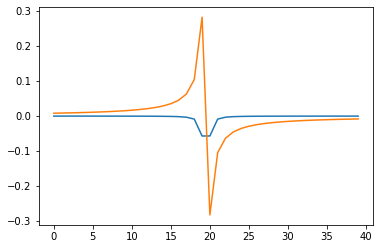

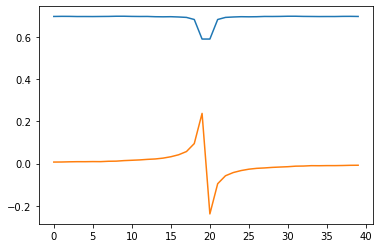

In [9]:
plt.plot(g.real)
plt.plot(g.imag)
plt.show()

plt.plot(se.real)
plt.plot(se.imag)
plt.show()

In [118]:
for ind in [44, 46, 52, 54]:
    comp = ci.GFComponent(index=ind, n_bands=1, n_ops=6, n_spins=2)
    print(comp.spins)

[1 0 1 0 1 1]
[1 0 1 1 0 1]
[1 1 0 0 1 1]
[1 1 0 1 0 1]


Let us now generate a list of existing components of the estimator. 
In general for one orbital, there could be $2^6=64$ components.
However, most of them are zero for two reasons:

1) two creation operators or two annihilation operators with same flavor at the same time, or

2) the $U$-matrix prefactor is zero.

In [119]:
component_list = {}
for a in range(2):  # outer index
    b = a  # for diagonal hybridization there is no other possibility
    outer_component = ci.GFComponent(n_bands=1, n_ops=2, n_spins=2,
                                    bands=2*(0,), spins=(a, b))
    ind_outer = outer_component.index
    ind_inner = {}
    for j in range(2):
        for k in range(2):
            for l in range(2):
                for m in range(2):
                    for n in range(2):
                        for o in range(2):
                            if (k == l or m == n):
                                continue
                            u_1 = u_antisymm_1[a, j, l, k]
                            u_2 = u_antisymm_2[m, n, b, o]
                            u_prefact = u_1 * u_2
                            if u_prefact == 0:
                                continue
                            comp = ci.GFComponent(n_bands=1, n_ops=6, n_spins=2, 
                                                  bands=6*(0,), spins=(j, k, l, m, n, o))
                            ind = comp.index
                            ind_inner.update({comp.index: u_prefact})
                            print(j, k, l, m, n, o, u_prefact, ind)
                            
    component_list.update({ind_outer: ind_inner})

1 0 1 0 1 1 -1.0 44
1 0 1 1 0 1 1.0 46
1 1 0 0 1 1 1.0 52
1 1 0 1 0 1 -1.0 54
0 0 1 0 1 0 -1.0 11
0 0 1 1 0 0 1.0 13
0 1 0 0 1 0 1.0 19
0 1 0 1 0 0 -1.0 21


In [20]:
component_list

{1: {44: -1.0, 46: 1.0, 52: 1.0, 54: -1.0},
 4: {11: -1.0, 13: 1.0, 19: 1.0, 21: -1.0}}

In [18]:
u_antisymm_1[0, 0]

array([[0., 0.],
       [0., 0.]])

Try it for n-orbital Kanamori.

Apparently, if we fix three indices of the U matrix, the fourth one is also fixed.

In [133]:
n_orb = 3
kanamori_interaction = ia.Kanamori(nbands=n_orb, u=5., v=3.5, j=0.75)
# kanamori_interaction.sym_u_matrix()
u_matrix = kanamori_interaction.convert_u_matrix()
u_antisymm_1 = 0.5 * (u_matrix - u_matrix.transpose((1, 0, 2, 3)))
u_antisymm_2 = 0.5 * (u_matrix - u_matrix.transpose((0, 1, 3, 2)))
u_antisymm_both = 0.5 * (u_antisymm_1 - u_antisymm_1.transpose((0, 1, 3, 2)))
# print(u_antisymm_1)

In [134]:
component_list = {}
all_ind = []

for a in range(2 * n_orb):  # outer index
    b = a  # for diagonal hybridization there is no other possibility
    outer_component = ci.GFComponent(n_bands=n_orb, n_ops=2, n_spins=2,
                                     bandspin=(a, b))
    ind_outer = outer_component.index
    ind_inner = {}
    print(a)
    for j in range(2 * n_orb):
        for k in range(2 * n_orb):
            for l in range(2 * n_orb):
                for m in range(2 * n_orb):
                    for n in range(2 * n_orb):
                        for o in range(2 * n_orb):
                            if (k == l or m == n):
                                continue
                            u_1 = u_antisymm_1[a, j, l, k]
                            u_2 = u_antisymm_2[m, n, b, o]
                            u_prefact = u_1 * u_2
                            if u_prefact == 0:
                                continue
                            comp = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2, 
                                                  bandspin=(j, k, l, m, n, o))
                            ind = comp.index
                            ind_inner.update({comp.index: {'u_prefact': u_prefact, 'perm_sign': None}})
                            all_ind.append(ind)
#                             print(j, k, l, m, n, o, u_prefact, ind)
                            
    
    component_list.update({ind_outer: ind_inner})
component_list

0
1
2
3
4
5


{1: {8000: {'u_prefact': -6.25, 'perm_sign': None},
  8007: {'u_prefact': -3.4375, 'perm_sign': None},
  8014: {'u_prefact': -4.375, 'perm_sign': None},
  8021: {'u_prefact': -3.4375, 'perm_sign': None},
  8028: {'u_prefact': -4.375, 'perm_sign': None},
  8030: {'u_prefact': 6.25, 'perm_sign': None},
  8044: {'u_prefact': 0.9375, 'perm_sign': None},
  8058: {'u_prefact': 0.9375, 'perm_sign': None},
  8067: {'u_prefact': 3.4375, 'perm_sign': None},
  8074: {'u_prefact': -0.9375, 'perm_sign': None},
  8084: {'u_prefact': -0.9375, 'perm_sign': None},
  8104: {'u_prefact': 4.375, 'perm_sign': None},
  8114: {'u_prefact': 0.9375, 'perm_sign': None},
  8141: {'u_prefact': 3.4375, 'perm_sign': None},
  8148: {'u_prefact': -0.9375, 'perm_sign': None},
  8168: {'u_prefact': -0.9375, 'perm_sign': None},
  8178: {'u_prefact': 4.375, 'perm_sign': None},
  8198: {'u_prefact': 0.9375, 'perm_sign': None},
  9080: {'u_prefact': 6.25, 'perm_sign': None},
  9087: {'u_prefact': 3.4375, 'perm_sign': None}

Apparently, if we fix three indices of the U matrix, the fourth one is also fixed.
This we show in the following cell:

In [135]:
for i1 in range(2 * n_orb):
    for i2 in range(2 * n_orb):
        for i3 in range(2 * n_orb):
            n0 = sum(u_antisymm_1[:, i1, i2, i3]!=0)
            n1 = sum(u_antisymm_1[i1, :, i2, i3]!=0)
            n2 = sum(u_antisymm_1[i1, i2, :, i3]!=0)
            n3 = sum(u_antisymm_1[i1, i2, i3, :]!=0)
            if n0 > 1 or n1 > 1 or n2 > 1 or n3 > 1:
                print(n0, n1, n2, n3)
for i1 in range(2 * n_orb):
    for i2 in range(2 * n_orb):
        for i3 in range(2 * n_orb):
            n0 = sum(u_antisymm_2[:, i1, i2, i3]!=0)
            n1 = sum(u_antisymm_2[i1, :, i2, i3]!=0)
            n2 = sum(u_antisymm_2[i1, i2, :, i3]!=0)
            n3 = sum(u_antisymm_2[i1, i2, i3, :]!=0)
            if n0 > 1 or n1 > 1 or n2 > 1 or n3 > 1:
                print(n0, n1, n2, n3)
                
for i1 in range(2 * n_orb):
    for i2 in range(2 * n_orb):
        for i3 in range(2 * n_orb):
            n0 = sum(u_antisymm_both[:, i1, i2, i3]!=0)
            n1 = sum(u_antisymm_both[i1, :, i2, i3]!=0)
            n2 = sum(u_antisymm_both[i1, i2, :, i3]!=0)
            n3 = sum(u_antisymm_both[i1, i2, i3, :]!=0)
            if n0 > 1 or n1 > 1 or n2 > 1 or n3 > 1:
                print(n0, n1, n2, n3)

In [136]:
def invert_spin(spin_list):
    """Flip all spins in spin_list, i.e. 0 <-> 1"""
    inverted_spin = [1 - s for s in spin_list]
    return inverted_spin

def swap_orb(orb_list, orb1, orb2):
    """Swap orb1 <-> orb2 in orb_list"""
    swapped_list = []
    for orb in orb_list:
        if orb == orb1:
            swapped_list.append(orb2)
        elif orb == orb2:
            swapped_list.append(orb1)
        else:
            swapped_list.append(orb)
    return swapped_list

def get_equivalent_indices(ind, paramag=True, orb_equiv=None, get_sign=False):
    """For an inner index ind, get all equivalent indices.
    
    There are several symmetries that we can exploit:
    1) exchanging operator pairs. This should work in all cases. 
       a) [ddag0 d1 d2](tau1) [ddag3 ddag4 d5](tau2) -> -[ddag0 d2 d1](tau1) [ddag3 ddag4 d5](tau2)
       b) [ddag0 d1 d2](tau1) [ddag3 ddag4 d5](tau2) -> -[ddag0 d1 d2](tau1) [ddag4 ddag3 d5](tau2)
       c) [ddag0 d1 d2](tau1) [ddag3 ddag4 d5](tau2) -> -[ddag0 d2 d1](tau1) [ddag4 ddag3 d5](tau2)
    2) For a paramagnetic system, we can flip all spins
    3) If we have degenerate orbitals, many more components are equivalent.
       orb_equiv=[[0, 1, 2]] tells that orbitals 0, 1 and 2 are equivalent.
       However, not yet all orbitaly symmetric components are obtained,
       since that's a bit tricky.
       
    The exchange of operator pairs in 1) introduces an extra sign (if one exchange is done)
    if we set get_sign to True, the sign is also returned
    """
    
    comp = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2, index=ind)
    bs = comp.bandspin
    
    # 1) exchange operators
    bs_ex_1 = [bs[0], bs[2], bs[1]] + bs[3:]
    bs_ex_2 = bs[:3] + [bs[4], bs[3], bs[5]]
    bs_ex_both = [bs[0], bs[2], bs[1], bs[4], bs[3], bs[5]]
    comp_ex_1 = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2, bandspin=bs_ex_1)
    comp_ex_2 = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2, bandspin=bs_ex_2)
    comp_ex_both = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2, bandspin=bs_ex_both)
    comp_list = [comp_ex_1, comp_ex_2, comp_ex_both]
    if get_sign:
        sign_list = [-1, -1, 1]
    
    # 2) paramagnetism
    if paramag:
        b, s = comp.bands, comp.spins
        comp_flip = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2,
                                   bands=b, spins=invert_spin(s))
        comp_ex_1_flip = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2,
                                        bands=comp_ex_1.bands, spins=invert_spin(comp_ex_1.spins))
        comp_ex_2_flip = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2,
                                        bands=comp_ex_2.bands, spins=invert_spin(comp_ex_2.spins))
        comp_ex_both_flip = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2,
                                        bands=comp_ex_both.bands, spins=invert_spin(comp_ex_both.spins))
        comp_list += [comp_flip, comp_ex_1_flip, comp_ex_2_flip, comp_ex_both_flip]
        if get_sign:
            sign_list += [1, -1, -1, 1]
    
    # 3) orbital equivalence
    comp_orb_equiv = []
    if get_sign:
        sign_list_equiv = []
    if orb_equiv is not None:
        for equiv_set in orb_equiv:
            n_eq = len(equiv_set)
            if n_eq <= 1:
                break
            for i_gf_comp, gf_comp in enumerate(comp_list):
                for i1 in range(len(equiv_set)):
                    for i2 in range(len(equiv_set)):
                        o1 = equiv_set[i1]
                        o2 = equiv_set[i2]
                        b = gf_comp.bands[:]
                        s = gf_comp.spins[:]
                        b_swapped = swap_orb(b, o1, o2)
                        print(o1, o2, b, b_swapped)
                        
                        comp_orb_equiv.append(ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2,
                                                             bands=b_swapped, spins=s))
                        if get_sign:
                            sign_list_equiv.append(sign_list[i_gf_comp])
                    
        comp_list += comp_orb_equiv
        if get_sign:
            sign_list += sign_list_equiv
        
    # return only the unique indices and corresponding signs
    ind_list_redundant = np.array([c.index for c in comp_list], dtype=int)
    ind_list_unique, unique_indices, unique_inverse = np.unique(ind_list_redundant, return_index=True, return_inverse=True)
    sign_list = np.array(sign_list)[unique_indices]
    
    if get_sign:
        return (ind_list_unique, sign_list)
    else:
        return ind_list

# comp = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2, index=8021)
# print(comp.bands, comp.spins, comp.index)
# for i in get_equivalent_indices(8021, paramag=True, orb_equiv=[[0, 1, 2]]):
#     comp = ci.GFComponent(n_bands=n_orb, n_ops=6, n_spins=2, index=i)
#     if np.allclose(np.array(comp.spins) - np.array([1, 0, 1, 0, 0, 0]), 0):
#         print(comp.bands, comp.spins, comp.index)


In [137]:
# filtered_ind = []
# all_inner_ind = []
# paramag = True
# orb_equiv = None
# for k in component_list.keys():
#     filtered_ind += component_list[k].keys()
#     all_inner_ind += component_list[k].keys()
# n_inner_full = len(all_inner_ind)

# i = 0
# while True:
#     eq_ind = get_equivalent_indices(filtered_ind[i], paramag=paramag, orb_equiv=orb_equiv)
#     for ind in eq_ind:
#         try:
#             filtered_ind.remove(ind)
#         except ValueError:
#             pass  # if the element was removed before
# #     print(i, len(filtered_ind))
#     if i >= len(filtered_ind) - 1:
#         break
#     else:
#         i += 1
# n_inner_red = len(filtered_ind)
# print(n_inner_full, '->', n_inner_red)


# Y = np.zeros((n_inner_full, n_inner_red), dtype=int)
# filtered_ind_set = set(filtered_ind)

# for i_full, ind_full in enumerate(all_inner_ind):
#     eq_ind = get_equivalent_indices(ind_full, paramag=paramag, orb_equiv=orb_equiv) + [ind_full,]
#     eq_ind_set = set(eq_ind)
#     intersection = list(eq_ind_set & filtered_ind_set)
#     if len(intersection) == 0:
#         raise ValueError('no matching equivalent index')
#     if len(intersection) > 1:
#         raise ValueError('more than one matching equivalent index')
        
    
#     position = filtered_ind.index(intersection[0])
        
#     Y[i_full, position] = 1  # still have to determine sign afterwards!!
    
# plt.figure(figsize=(20, 4))
# plt.pcolormesh(Y.T)
# # plt.colorbar()
# plt.show()

In [141]:
paramag = True
orb_equiv = [[0, 1, 2]]
computation_plan = copy.deepcopy(component_list)
for outer_ind in computation_plan.keys():
    for inner_ind in computation_plan[outer_ind].keys():
        component_inner = computation_plan[outer_ind][inner_ind]
        if component_inner['perm_sign'] is None:
            eq_ind, sign = get_equivalent_indices(inner_ind, paramag=paramag, orb_equiv=orb_equiv, get_sign=True)
            for outer_ind_2 in computation_plan.keys():
                for inner_ind_2 in computation_plan[outer_ind_2].keys():
                    if inner_ind_2 in eq_ind:
                        this_sign = sign[np.where(eq_ind == inner_ind_2)][0]
                        computation_plan[outer_ind_2][inner_ind_2].update({'equivalent_component': inner_ind,
                                                                            'perm_sign': this_sign})
                

for outer_ind in computation_plan.keys():
    for inner_ind in computation_plan[outer_ind].keys():
        if not 'equivalent_component' in computation_plan[outer_ind][inner_ind].keys():
            computation_plan[outer_ind][inner_ind].update({'perm_sign': 1, 'equivalent_component': inner_ind})
            
sample_groups = []
for outer_ind in computation_plan.keys():
    for inner_ind in computation_plan[outer_ind].keys():
        this_ind = computation_plan[outer_ind][inner_ind]['equivalent_component']
        if not this_ind in sample_groups:
            sample_groups.append(this_ind)
            
print("Need to sample {} groups: {}".format(len(sample_groups), sample_groups))

0 0 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
0 1 [0 0 0 0 0 0] [1, 1, 1, 1, 1, 1]
0 2 [0 0 0 0 0 0] [2, 2, 2, 2, 2, 2]
1 0 [0 0 0 0 0 0] [1, 1, 1, 1, 1, 1]
1 1 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
1 2 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
2 0 [0 0 0 0 0 0] [2, 2, 2, 2, 2, 2]
2 1 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
2 2 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
0 0 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
0 1 [0 0 0 0 0 0] [1, 1, 1, 1, 1, 1]
0 2 [0 0 0 0 0 0] [2, 2, 2, 2, 2, 2]
1 0 [0 0 0 0 0 0] [1, 1, 1, 1, 1, 1]
1 1 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
1 2 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
2 0 [0 0 0 0 0 0] [2, 2, 2, 2, 2, 2]
2 1 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
2 2 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
0 0 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
0 1 [0 0 0 0 0 0] [1, 1, 1, 1, 1, 1]
0 2 [0 0 0 0 0 0] [2, 2, 2, 2, 2, 2]
1 0 [0 0 0 0 0 0] [1, 1, 1, 1, 1, 1]
1 1 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
1 2 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
2 0 [0 0 0 0 0 0] [2, 2, 2, 2, 2, 2]
2 1 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
2 2 [0 0 0 0 0 0] [0, 0, 0, 0, 0, 0]
0

2 0 [0 0 0 0 2 2] [2, 2, 2, 2, 0, 0]
2 1 [0 0 0 0 2 2] [0, 0, 0, 0, 1, 1]
2 2 [0 0 0 0 2 2] [0, 0, 0, 0, 2, 2]
0 0 [0 0 0 2 0 2] [0, 0, 0, 2, 0, 2]
0 1 [0 0 0 2 0 2] [1, 1, 1, 2, 1, 2]
0 2 [0 0 0 2 0 2] [2, 2, 2, 0, 2, 0]
1 0 [0 0 0 2 0 2] [1, 1, 1, 2, 1, 2]
1 1 [0 0 0 2 0 2] [0, 0, 0, 2, 0, 2]
1 2 [0 0 0 2 0 2] [0, 0, 0, 1, 0, 1]
2 0 [0 0 0 2 0 2] [2, 2, 2, 0, 2, 0]
2 1 [0 0 0 2 0 2] [0, 0, 0, 1, 0, 1]
2 2 [0 0 0 2 0 2] [0, 0, 0, 2, 0, 2]
0 0 [0 0 0 2 0 2] [0, 0, 0, 2, 0, 2]
0 1 [0 0 0 2 0 2] [1, 1, 1, 2, 1, 2]
0 2 [0 0 0 2 0 2] [2, 2, 2, 0, 2, 0]
1 0 [0 0 0 2 0 2] [1, 1, 1, 2, 1, 2]
1 1 [0 0 0 2 0 2] [0, 0, 0, 2, 0, 2]
1 2 [0 0 0 2 0 2] [0, 0, 0, 1, 0, 1]
2 0 [0 0 0 2 0 2] [2, 2, 2, 0, 2, 0]
2 1 [0 0 0 2 0 2] [0, 0, 0, 1, 0, 1]
2 2 [0 0 0 2 0 2] [0, 0, 0, 2, 0, 2]
0 0 [0 0 0 1 1 0] [0, 0, 0, 1, 1, 0]
0 1 [0 0 0 1 1 0] [1, 1, 1, 0, 0, 1]
0 2 [0 0 0 1 1 0] [2, 2, 2, 1, 1, 2]
1 0 [0 0 0 1 1 0] [1, 1, 1, 0, 0, 1]
1 1 [0 0 0 1 1 0] [0, 0, 0, 1, 1, 0]
1 2 [0 0 0 1 1 0] [0, 0, 0, 2, 2, 0]
2

1 2 [0 1 1 2 0 2] [0, 2, 2, 1, 0, 1]
2 0 [0 1 1 2 0 2] [2, 1, 1, 0, 2, 0]
2 1 [0 1 1 2 0 2] [0, 2, 2, 1, 0, 1]
2 2 [0 1 1 2 0 2] [0, 1, 1, 2, 0, 2]
0 0 [0 1 1 2 0 2] [0, 1, 1, 2, 0, 2]
0 1 [0 1 1 2 0 2] [1, 0, 0, 2, 1, 2]
0 2 [0 1 1 2 0 2] [2, 1, 1, 0, 2, 0]
1 0 [0 1 1 2 0 2] [1, 0, 0, 2, 1, 2]
1 1 [0 1 1 2 0 2] [0, 1, 1, 2, 0, 2]
1 2 [0 1 1 2 0 2] [0, 2, 2, 1, 0, 1]
2 0 [0 1 1 2 0 2] [2, 1, 1, 0, 2, 0]
2 1 [0 1 1 2 0 2] [0, 2, 2, 1, 0, 1]
2 2 [0 1 1 2 0 2] [0, 1, 1, 2, 0, 2]
0 0 [0 1 1 0 1 1] [0, 1, 1, 0, 1, 1]
0 1 [0 1 1 0 1 1] [1, 0, 0, 1, 0, 0]
0 2 [0 1 1 0 1 1] [2, 1, 1, 2, 1, 1]
1 0 [0 1 1 0 1 1] [1, 0, 0, 1, 0, 0]
1 1 [0 1 1 0 1 1] [0, 1, 1, 0, 1, 1]
1 2 [0 1 1 0 1 1] [0, 2, 2, 0, 2, 2]
2 0 [0 1 1 0 1 1] [2, 1, 1, 2, 1, 1]
2 1 [0 1 1 0 1 1] [0, 2, 2, 0, 2, 2]
2 2 [0 1 1 0 1 1] [0, 1, 1, 0, 1, 1]
0 0 [0 1 1 1 0 1] [0, 1, 1, 1, 0, 1]
0 1 [0 1 1 1 0 1] [1, 0, 0, 0, 1, 0]
0 2 [0 1 1 1 0 1] [2, 1, 1, 1, 2, 1]
1 0 [0 1 1 1 0 1] [1, 0, 0, 0, 1, 0]
1 1 [0 1 1 1 0 1] [0, 1, 1, 1, 0, 1]
1

2 1 [0 2 2 1 0 1] [0, 1, 1, 2, 0, 2]
2 2 [0 2 2 1 0 1] [0, 2, 2, 1, 0, 1]
0 0 [0 2 2 1 0 1] [0, 2, 2, 1, 0, 1]
0 1 [0 2 2 1 0 1] [1, 2, 2, 0, 1, 0]
0 2 [0 2 2 1 0 1] [2, 0, 0, 1, 2, 1]
1 0 [0 2 2 1 0 1] [1, 2, 2, 0, 1, 0]
1 1 [0 2 2 1 0 1] [0, 2, 2, 1, 0, 1]
1 2 [0 2 2 1 0 1] [0, 1, 1, 2, 0, 2]
2 0 [0 2 2 1 0 1] [2, 0, 0, 1, 2, 1]
2 1 [0 2 2 1 0 1] [0, 1, 1, 2, 0, 2]
2 2 [0 2 2 1 0 1] [0, 2, 2, 1, 0, 1]
0 0 [0 2 2 0 1 1] [0, 2, 2, 0, 1, 1]
0 1 [0 2 2 0 1 1] [1, 2, 2, 1, 0, 0]
0 2 [0 2 2 0 1 1] [2, 0, 0, 2, 1, 1]
1 0 [0 2 2 0 1 1] [1, 2, 2, 1, 0, 0]
1 1 [0 2 2 0 1 1] [0, 2, 2, 0, 1, 1]
1 2 [0 2 2 0 1 1] [0, 1, 1, 0, 2, 2]
2 0 [0 2 2 0 1 1] [2, 0, 0, 2, 1, 1]
2 1 [0 2 2 0 1 1] [0, 1, 1, 0, 2, 2]
2 2 [0 2 2 0 1 1] [0, 2, 2, 0, 1, 1]
0 0 [0 2 2 1 0 1] [0, 2, 2, 1, 0, 1]
0 1 [0 2 2 1 0 1] [1, 2, 2, 0, 1, 0]
0 2 [0 2 2 1 0 1] [2, 0, 0, 1, 2, 1]
1 0 [0 2 2 1 0 1] [1, 2, 2, 0, 1, 0]
1 1 [0 2 2 1 0 1] [0, 2, 2, 1, 0, 1]
1 2 [0 2 2 1 0 1] [0, 1, 1, 2, 0, 2]
2 0 [0 2 2 1 0 1] [2, 0, 0, 1, 2, 1]
2

0 0 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
0 1 [0 2 2 2 2 0] [1, 2, 2, 2, 2, 1]
0 2 [0 2 2 2 2 0] [2, 0, 0, 0, 0, 2]
1 0 [0 2 2 2 2 0] [1, 2, 2, 2, 2, 1]
1 1 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
1 2 [0 2 2 2 2 0] [0, 1, 1, 1, 1, 0]
2 0 [0 2 2 2 2 0] [2, 0, 0, 0, 0, 2]
2 1 [0 2 2 2 2 0] [0, 1, 1, 1, 1, 0]
2 2 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
0 0 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
0 1 [0 2 2 2 2 0] [1, 2, 2, 2, 2, 1]
0 2 [0 2 2 2 2 0] [2, 0, 0, 0, 0, 2]
1 0 [0 2 2 2 2 0] [1, 2, 2, 2, 2, 1]
1 1 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
1 2 [0 2 2 2 2 0] [0, 1, 1, 1, 1, 0]
2 0 [0 2 2 2 2 0] [2, 0, 0, 0, 0, 2]
2 1 [0 2 2 2 2 0] [0, 1, 1, 1, 1, 0]
2 2 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
0 0 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
0 1 [0 2 2 2 2 0] [1, 2, 2, 2, 2, 1]
0 2 [0 2 2 2 2 0] [2, 0, 0, 0, 0, 2]
1 0 [0 2 2 2 2 0] [1, 2, 2, 2, 2, 1]
1 1 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
1 2 [0 2 2 2 2 0] [0, 1, 1, 1, 1, 0]
2 0 [0 2 2 2 2 0] [2, 0, 0, 0, 0, 2]
2 1 [0 2 2 2 2 0] [0, 1, 1, 1, 1, 0]
2 2 [0 2 2 2 2 0] [0, 2, 2, 2, 2, 0]
0

0 0 [1 1 0 0 2 2] [1, 1, 0, 0, 2, 2]
0 1 [1 1 0 0 2 2] [0, 0, 1, 1, 2, 2]
0 2 [1 1 0 0 2 2] [1, 1, 2, 2, 0, 0]
1 0 [1 1 0 0 2 2] [0, 0, 1, 1, 2, 2]
1 1 [1 1 0 0 2 2] [1, 1, 0, 0, 2, 2]
1 2 [1 1 0 0 2 2] [2, 2, 0, 0, 1, 1]
2 0 [1 1 0 0 2 2] [1, 1, 2, 2, 0, 0]
2 1 [1 1 0 0 2 2] [2, 2, 0, 0, 1, 1]
2 2 [1 1 0 0 2 2] [1, 1, 0, 0, 2, 2]
0 0 [1 0 1 2 0 2] [1, 0, 1, 2, 0, 2]
0 1 [1 0 1 2 0 2] [0, 1, 0, 2, 1, 2]
0 2 [1 0 1 2 0 2] [1, 2, 1, 0, 2, 0]
1 0 [1 0 1 2 0 2] [0, 1, 0, 2, 1, 2]
1 1 [1 0 1 2 0 2] [1, 0, 1, 2, 0, 2]
1 2 [1 0 1 2 0 2] [2, 0, 2, 1, 0, 1]
2 0 [1 0 1 2 0 2] [1, 2, 1, 0, 2, 0]
2 1 [1 0 1 2 0 2] [2, 0, 2, 1, 0, 1]
2 2 [1 0 1 2 0 2] [1, 0, 1, 2, 0, 2]
0 0 [1 1 0 2 0 2] [1, 1, 0, 2, 0, 2]
0 1 [1 1 0 2 0 2] [0, 0, 1, 2, 1, 2]
0 2 [1 1 0 2 0 2] [1, 1, 2, 0, 2, 0]
1 0 [1 1 0 2 0 2] [0, 0, 1, 2, 1, 2]
1 1 [1 1 0 2 0 2] [1, 1, 0, 2, 0, 2]
1 2 [1 1 0 2 0 2] [2, 2, 0, 1, 0, 1]
2 0 [1 1 0 2 0 2] [1, 1, 2, 0, 2, 0]
2 1 [1 1 0 2 0 2] [2, 2, 0, 1, 0, 1]
2 2 [1 1 0 2 0 2] [1, 1, 0, 2, 0, 2]
0

1 0 [1 1 0 2 0 2] [0, 0, 1, 2, 1, 2]
1 1 [1 1 0 2 0 2] [1, 1, 0, 2, 0, 2]
1 2 [1 1 0 2 0 2] [2, 2, 0, 1, 0, 1]
2 0 [1 1 0 2 0 2] [1, 1, 2, 0, 2, 0]
2 1 [1 1 0 2 0 2] [2, 2, 0, 1, 0, 1]
2 2 [1 1 0 2 0 2] [1, 1, 0, 2, 0, 2]
0 0 [1 1 0 0 2 2] [1, 1, 0, 0, 2, 2]
0 1 [1 1 0 0 2 2] [0, 0, 1, 1, 2, 2]
0 2 [1 1 0 0 2 2] [1, 1, 2, 2, 0, 0]
1 0 [1 1 0 0 2 2] [0, 0, 1, 1, 2, 2]
1 1 [1 1 0 0 2 2] [1, 1, 0, 0, 2, 2]
1 2 [1 1 0 0 2 2] [2, 2, 0, 0, 1, 1]
2 0 [1 1 0 0 2 2] [1, 1, 2, 2, 0, 0]
2 1 [1 1 0 0 2 2] [2, 2, 0, 0, 1, 1]
2 2 [1 1 0 0 2 2] [1, 1, 0, 0, 2, 2]
0 0 [1 0 1 2 0 2] [1, 0, 1, 2, 0, 2]
0 1 [1 0 1 2 0 2] [0, 1, 0, 2, 1, 2]
0 2 [1 0 1 2 0 2] [1, 2, 1, 0, 2, 0]
1 0 [1 0 1 2 0 2] [0, 1, 0, 2, 1, 2]
1 1 [1 0 1 2 0 2] [1, 0, 1, 2, 0, 2]
1 2 [1 0 1 2 0 2] [2, 0, 2, 1, 0, 1]
2 0 [1 0 1 2 0 2] [1, 2, 1, 0, 2, 0]
2 1 [1 0 1 2 0 2] [2, 0, 2, 1, 0, 1]
2 2 [1 0 1 2 0 2] [1, 0, 1, 2, 0, 2]
0 0 [1 1 0 2 0 2] [1, 1, 0, 2, 0, 2]
0 1 [1 1 0 2 0 2] [0, 0, 1, 2, 1, 2]
0 2 [1 1 0 2 0 2] [1, 1, 2, 0, 2, 0]
1

0 0 [1 1 0 1 0 1] [1, 1, 0, 1, 0, 1]
0 1 [1 1 0 1 0 1] [0, 0, 1, 0, 1, 0]
0 2 [1 1 0 1 0 1] [1, 1, 2, 1, 2, 1]
1 0 [1 1 0 1 0 1] [0, 0, 1, 0, 1, 0]
1 1 [1 1 0 1 0 1] [1, 1, 0, 1, 0, 1]
1 2 [1 1 0 1 0 1] [2, 2, 0, 2, 0, 2]
2 0 [1 1 0 1 0 1] [1, 1, 2, 1, 2, 1]
2 1 [1 1 0 1 0 1] [2, 2, 0, 2, 0, 2]
2 2 [1 1 0 1 0 1] [1, 1, 0, 1, 0, 1]
0 0 [1 0 1 0 1 1] [1, 0, 1, 0, 1, 1]
0 1 [1 0 1 0 1 1] [0, 1, 0, 1, 0, 0]
0 2 [1 0 1 0 1 1] [1, 2, 1, 2, 1, 1]
1 0 [1 0 1 0 1 1] [0, 1, 0, 1, 0, 0]
1 1 [1 0 1 0 1 1] [1, 0, 1, 0, 1, 1]
1 2 [1 0 1 0 1 1] [2, 0, 2, 0, 2, 2]
2 0 [1 0 1 0 1 1] [1, 2, 1, 2, 1, 1]
2 1 [1 0 1 0 1 1] [2, 0, 2, 0, 2, 2]
2 2 [1 0 1 0 1 1] [1, 0, 1, 0, 1, 1]
0 0 [1 1 0 0 1 1] [1, 1, 0, 0, 1, 1]
0 1 [1 1 0 0 1 1] [0, 0, 1, 1, 0, 0]
0 2 [1 1 0 0 1 1] [1, 1, 2, 2, 1, 1]
1 0 [1 1 0 0 1 1] [0, 0, 1, 1, 0, 0]
1 1 [1 1 0 0 1 1] [1, 1, 0, 0, 1, 1]
1 2 [1 1 0 0 1 1] [2, 2, 0, 0, 2, 2]
2 0 [1 1 0 0 1 1] [1, 1, 2, 2, 1, 1]
2 1 [1 1 0 0 1 1] [2, 2, 0, 0, 2, 2]
2 2 [1 1 0 0 1 1] [1, 1, 0, 0, 1, 1]
0

2 1 [1 1 0 1 1 0] [2, 2, 0, 2, 2, 0]
2 2 [1 1 0 1 1 0] [1, 1, 0, 1, 1, 0]
0 0 [1 0 1 1 1 0] [1, 0, 1, 1, 1, 0]
0 1 [1 0 1 1 1 0] [0, 1, 0, 0, 0, 1]
0 2 [1 0 1 1 1 0] [1, 2, 1, 1, 1, 2]
1 0 [1 0 1 1 1 0] [0, 1, 0, 0, 0, 1]
1 1 [1 0 1 1 1 0] [1, 0, 1, 1, 1, 0]
1 2 [1 0 1 1 1 0] [2, 0, 2, 2, 2, 0]
2 0 [1 0 1 1 1 0] [1, 2, 1, 1, 1, 2]
2 1 [1 0 1 1 1 0] [2, 0, 2, 2, 2, 0]
2 2 [1 0 1 1 1 0] [1, 0, 1, 1, 1, 0]
0 0 [1 1 0 1 1 0] [1, 1, 0, 1, 1, 0]
0 1 [1 1 0 1 1 0] [0, 0, 1, 0, 0, 1]
0 2 [1 1 0 1 1 0] [1, 1, 2, 1, 1, 2]
1 0 [1 1 0 1 1 0] [0, 0, 1, 0, 0, 1]
1 1 [1 1 0 1 1 0] [1, 1, 0, 1, 1, 0]
1 2 [1 1 0 1 1 0] [2, 2, 0, 2, 2, 0]
2 0 [1 1 0 1 1 0] [1, 1, 2, 1, 1, 2]
2 1 [1 1 0 1 1 0] [2, 2, 0, 2, 2, 0]
2 2 [1 1 0 1 1 0] [1, 1, 0, 1, 1, 0]
0 0 [1 0 1 1 1 0] [1, 0, 1, 1, 1, 0]
0 1 [1 0 1 1 1 0] [0, 1, 0, 0, 0, 1]
0 2 [1 0 1 1 1 0] [1, 2, 1, 1, 1, 2]
1 0 [1 0 1 1 1 0] [0, 1, 0, 0, 0, 1]
1 1 [1 0 1 1 1 0] [1, 0, 1, 1, 1, 0]
1 2 [1 0 1 1 1 0] [2, 0, 2, 2, 2, 0]
2 0 [1 0 1 1 1 0] [1, 2, 1, 1, 1, 2]
2

0 0 [2 2 0 0 1 1] [2, 2, 0, 0, 1, 1]
0 1 [2 2 0 0 1 1] [2, 2, 1, 1, 0, 0]
0 2 [2 2 0 0 1 1] [0, 0, 2, 2, 1, 1]
1 0 [2 2 0 0 1 1] [2, 2, 1, 1, 0, 0]
1 1 [2 2 0 0 1 1] [2, 2, 0, 0, 1, 1]
1 2 [2 2 0 0 1 1] [1, 1, 0, 0, 2, 2]
2 0 [2 2 0 0 1 1] [0, 0, 2, 2, 1, 1]
2 1 [2 2 0 0 1 1] [1, 1, 0, 0, 2, 2]
2 2 [2 2 0 0 1 1] [2, 2, 0, 0, 1, 1]
0 0 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
0 1 [2 0 2 1 0 1] [2, 1, 2, 0, 1, 0]
0 2 [2 0 2 1 0 1] [0, 2, 0, 1, 2, 1]
1 0 [2 0 2 1 0 1] [2, 1, 2, 0, 1, 0]
1 1 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
1 2 [2 0 2 1 0 1] [1, 0, 1, 2, 0, 2]
2 0 [2 0 2 1 0 1] [0, 2, 0, 1, 2, 1]
2 1 [2 0 2 1 0 1] [1, 0, 1, 2, 0, 2]
2 2 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
0 0 [2 2 0 1 0 1] [2, 2, 0, 1, 0, 1]
0 1 [2 2 0 1 0 1] [2, 2, 1, 0, 1, 0]
0 2 [2 2 0 1 0 1] [0, 0, 2, 1, 2, 1]
1 0 [2 2 0 1 0 1] [2, 2, 1, 0, 1, 0]
1 1 [2 2 0 1 0 1] [2, 2, 0, 1, 0, 1]
1 2 [2 2 0 1 0 1] [1, 1, 0, 2, 0, 2]
2 0 [2 2 0 1 0 1] [0, 0, 2, 1, 2, 1]
2 1 [2 2 0 1 0 1] [1, 1, 0, 2, 0, 2]
2 2 [2 2 0 1 0 1] [2, 2, 0, 1, 0, 1]
0

0 0 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
0 1 [2 0 2 1 0 1] [2, 1, 2, 0, 1, 0]
0 2 [2 0 2 1 0 1] [0, 2, 0, 1, 2, 1]
1 0 [2 0 2 1 0 1] [2, 1, 2, 0, 1, 0]
1 1 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
1 2 [2 0 2 1 0 1] [1, 0, 1, 2, 0, 2]
2 0 [2 0 2 1 0 1] [0, 2, 0, 1, 2, 1]
2 1 [2 0 2 1 0 1] [1, 0, 1, 2, 0, 2]
2 2 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
0 0 [2 2 0 1 0 1] [2, 2, 0, 1, 0, 1]
0 1 [2 2 0 1 0 1] [2, 2, 1, 0, 1, 0]
0 2 [2 2 0 1 0 1] [0, 0, 2, 1, 2, 1]
1 0 [2 2 0 1 0 1] [2, 2, 1, 0, 1, 0]
1 1 [2 2 0 1 0 1] [2, 2, 0, 1, 0, 1]
1 2 [2 2 0 1 0 1] [1, 1, 0, 2, 0, 2]
2 0 [2 2 0 1 0 1] [0, 0, 2, 1, 2, 1]
2 1 [2 2 0 1 0 1] [1, 1, 0, 2, 0, 2]
2 2 [2 2 0 1 0 1] [2, 2, 0, 1, 0, 1]
0 0 [2 0 2 0 1 1] [2, 0, 2, 0, 1, 1]
0 1 [2 0 2 0 1 1] [2, 1, 2, 1, 0, 0]
0 2 [2 0 2 0 1 1] [0, 2, 0, 2, 1, 1]
1 0 [2 0 2 0 1 1] [2, 1, 2, 1, 0, 0]
1 1 [2 0 2 0 1 1] [2, 0, 2, 0, 1, 1]
1 2 [2 0 2 0 1 1] [1, 0, 1, 0, 2, 2]
2 0 [2 0 2 0 1 1] [0, 2, 0, 2, 1, 1]
2 1 [2 0 2 0 1 1] [1, 0, 1, 0, 2, 2]
2 2 [2 0 2 0 1 1] [2, 0, 2, 0, 1, 1]
0

1 2 [2 2 0 2 2 0] [1, 1, 0, 1, 1, 0]
2 0 [2 2 0 2 2 0] [0, 0, 2, 0, 0, 2]
2 1 [2 2 0 2 2 0] [1, 1, 0, 1, 1, 0]
2 2 [2 2 0 2 2 0] [2, 2, 0, 2, 2, 0]
0 0 [2 0 2 2 2 0] [2, 0, 2, 2, 2, 0]
0 1 [2 0 2 2 2 0] [2, 1, 2, 2, 2, 1]
0 2 [2 0 2 2 2 0] [0, 2, 0, 0, 0, 2]
1 0 [2 0 2 2 2 0] [2, 1, 2, 2, 2, 1]
1 1 [2 0 2 2 2 0] [2, 0, 2, 2, 2, 0]
1 2 [2 0 2 2 2 0] [1, 0, 1, 1, 1, 0]
2 0 [2 0 2 2 2 0] [0, 2, 0, 0, 0, 2]
2 1 [2 0 2 2 2 0] [1, 0, 1, 1, 1, 0]
2 2 [2 0 2 2 2 0] [2, 0, 2, 2, 2, 0]
0 0 [2 2 0 2 2 0] [2, 2, 0, 2, 2, 0]
0 1 [2 2 0 2 2 0] [2, 2, 1, 2, 2, 1]
0 2 [2 2 0 2 2 0] [0, 0, 2, 0, 0, 2]
1 0 [2 2 0 2 2 0] [2, 2, 1, 2, 2, 1]
1 1 [2 2 0 2 2 0] [2, 2, 0, 2, 2, 0]
1 2 [2 2 0 2 2 0] [1, 1, 0, 1, 1, 0]
2 0 [2 2 0 2 2 0] [0, 0, 2, 0, 0, 2]
2 1 [2 2 0 2 2 0] [1, 1, 0, 1, 1, 0]
2 2 [2 2 0 2 2 0] [2, 2, 0, 2, 2, 0]
0 0 [2 0 2 2 2 0] [2, 0, 2, 2, 2, 0]
0 1 [2 0 2 2 2 0] [2, 1, 2, 2, 2, 1]
0 2 [2 0 2 2 2 0] [0, 2, 0, 0, 0, 2]
1 0 [2 0 2 2 2 0] [2, 1, 2, 2, 2, 1]
1 1 [2 0 2 2 2 0] [2, 0, 2, 2, 2, 0]
1

2 1 [2 0 2 0 1 1] [1, 0, 1, 0, 2, 2]
2 2 [2 0 2 0 1 1] [2, 0, 2, 0, 1, 1]
0 0 [2 2 0 0 1 1] [2, 2, 0, 0, 1, 1]
0 1 [2 2 0 0 1 1] [2, 2, 1, 1, 0, 0]
0 2 [2 2 0 0 1 1] [0, 0, 2, 2, 1, 1]
1 0 [2 2 0 0 1 1] [2, 2, 1, 1, 0, 0]
1 1 [2 2 0 0 1 1] [2, 2, 0, 0, 1, 1]
1 2 [2 2 0 0 1 1] [1, 1, 0, 0, 2, 2]
2 0 [2 2 0 0 1 1] [0, 0, 2, 2, 1, 1]
2 1 [2 2 0 0 1 1] [1, 1, 0, 0, 2, 2]
2 2 [2 2 0 0 1 1] [2, 2, 0, 0, 1, 1]
0 0 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
0 1 [2 0 2 1 0 1] [2, 1, 2, 0, 1, 0]
0 2 [2 0 2 1 0 1] [0, 2, 0, 1, 2, 1]
1 0 [2 0 2 1 0 1] [2, 1, 2, 0, 1, 0]
1 1 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
1 2 [2 0 2 1 0 1] [1, 0, 1, 2, 0, 2]
2 0 [2 0 2 1 0 1] [0, 2, 0, 1, 2, 1]
2 1 [2 0 2 1 0 1] [1, 0, 1, 2, 0, 2]
2 2 [2 0 2 1 0 1] [2, 0, 2, 1, 0, 1]
0 0 [2 2 0 1 0 1] [2, 2, 0, 1, 0, 1]
0 1 [2 2 0 1 0 1] [2, 2, 1, 0, 1, 0]
0 2 [2 2 0 1 0 1] [0, 0, 2, 1, 2, 1]
1 0 [2 2 0 1 0 1] [2, 2, 1, 0, 1, 0]
1 1 [2 2 0 1 0 1] [2, 2, 0, 1, 0, 1]
1 2 [2 2 0 1 0 1] [1, 1, 0, 2, 0, 2]
2 0 [2 2 0 1 0 1] [0, 0, 2, 1, 2, 1]
2

1 2 [0 0 1 1 1 1] [0, 0, 2, 2, 2, 2]
2 0 [0 0 1 1 1 1] [2, 2, 1, 1, 1, 1]
2 1 [0 0 1 1 1 1] [0, 0, 2, 2, 2, 2]
2 2 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
0 0 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
0 1 [0 1 0 1 1 1] [1, 0, 1, 0, 0, 0]
0 2 [0 1 0 1 1 1] [2, 1, 2, 1, 1, 1]
1 0 [0 1 0 1 1 1] [1, 0, 1, 0, 0, 0]
1 1 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
1 2 [0 1 0 1 1 1] [0, 2, 0, 2, 2, 2]
2 0 [0 1 0 1 1 1] [2, 1, 2, 1, 1, 1]
2 1 [0 1 0 1 1 1] [0, 2, 0, 2, 2, 2]
2 2 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
0 0 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
0 1 [0 0 1 1 1 1] [1, 1, 0, 0, 0, 0]
0 2 [0 0 1 1 1 1] [2, 2, 1, 1, 1, 1]
1 0 [0 0 1 1 1 1] [1, 1, 0, 0, 0, 0]
1 1 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
1 2 [0 0 1 1 1 1] [0, 0, 2, 2, 2, 2]
2 0 [0 0 1 1 1 1] [2, 2, 1, 1, 1, 1]
2 1 [0 0 1 1 1 1] [0, 0, 2, 2, 2, 2]
2 2 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
0 0 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
0 1 [0 1 0 1 1 1] [1, 0, 1, 0, 0, 0]
0 2 [0 1 0 1 1 1] [2, 1, 2, 1, 1, 1]
1 0 [0 1 0 1 1 1] [1, 0, 1, 0, 0, 0]
1 1 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
1

2 1 [0 0 1 1 0 0] [0, 0, 2, 2, 0, 0]
2 2 [0 0 1 1 0 0] [0, 0, 1, 1, 0, 0]
0 0 [0 1 0 0 1 0] [0, 1, 0, 0, 1, 0]
0 1 [0 1 0 0 1 0] [1, 0, 1, 1, 0, 1]
0 2 [0 1 0 0 1 0] [2, 1, 2, 2, 1, 2]
1 0 [0 1 0 0 1 0] [1, 0, 1, 1, 0, 1]
1 1 [0 1 0 0 1 0] [0, 1, 0, 0, 1, 0]
1 2 [0 1 0 0 1 0] [0, 2, 0, 0, 2, 0]
2 0 [0 1 0 0 1 0] [2, 1, 2, 2, 1, 2]
2 1 [0 1 0 0 1 0] [0, 2, 0, 0, 2, 0]
2 2 [0 1 0 0 1 0] [0, 1, 0, 0, 1, 0]
0 0 [0 0 1 0 1 0] [0, 0, 1, 0, 1, 0]
0 1 [0 0 1 0 1 0] [1, 1, 0, 1, 0, 1]
0 2 [0 0 1 0 1 0] [2, 2, 1, 2, 1, 2]
1 0 [0 0 1 0 1 0] [1, 1, 0, 1, 0, 1]
1 1 [0 0 1 0 1 0] [0, 0, 1, 0, 1, 0]
1 2 [0 0 1 0 1 0] [0, 0, 2, 0, 2, 0]
2 0 [0 0 1 0 1 0] [2, 2, 1, 2, 1, 2]
2 1 [0 0 1 0 1 0] [0, 0, 2, 0, 2, 0]
2 2 [0 0 1 0 1 0] [0, 0, 1, 0, 1, 0]
0 0 [0 0 1 1 2 2] [0, 0, 1, 1, 2, 2]
0 1 [0 0 1 1 2 2] [1, 1, 0, 0, 2, 2]
0 2 [0 0 1 1 2 2] [2, 2, 1, 1, 0, 0]
1 0 [0 0 1 1 2 2] [1, 1, 0, 0, 2, 2]
1 1 [0 0 1 1 2 2] [0, 0, 1, 1, 2, 2]
1 2 [0 0 1 1 2 2] [0, 0, 2, 2, 1, 1]
2 0 [0 0 1 1 2 2] [2, 2, 1, 1, 0, 0]
2

2 0 [0 1 0 1 1 1] [2, 1, 2, 1, 1, 1]
2 1 [0 1 0 1 1 1] [0, 2, 0, 2, 2, 2]
2 2 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
0 0 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
0 1 [0 0 1 1 1 1] [1, 1, 0, 0, 0, 0]
0 2 [0 0 1 1 1 1] [2, 2, 1, 1, 1, 1]
1 0 [0 0 1 1 1 1] [1, 1, 0, 0, 0, 0]
1 1 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
1 2 [0 0 1 1 1 1] [0, 0, 2, 2, 2, 2]
2 0 [0 0 1 1 1 1] [2, 2, 1, 1, 1, 1]
2 1 [0 0 1 1 1 1] [0, 0, 2, 2, 2, 2]
2 2 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
0 0 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
0 1 [0 1 0 1 1 1] [1, 0, 1, 0, 0, 0]
0 2 [0 1 0 1 1 1] [2, 1, 2, 1, 1, 1]
1 0 [0 1 0 1 1 1] [1, 0, 1, 0, 0, 0]
1 1 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
1 2 [0 1 0 1 1 1] [0, 2, 0, 2, 2, 2]
2 0 [0 1 0 1 1 1] [2, 1, 2, 1, 1, 1]
2 1 [0 1 0 1 1 1] [0, 2, 0, 2, 2, 2]
2 2 [0 1 0 1 1 1] [0, 1, 0, 1, 1, 1]
0 0 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
0 1 [0 0 1 1 1 1] [1, 1, 0, 0, 0, 0]
0 2 [0 0 1 1 1 1] [2, 2, 1, 1, 1, 1]
1 0 [0 0 1 1 1 1] [1, 1, 0, 0, 0, 0]
1 1 [0 0 1 1 1 1] [0, 0, 1, 1, 1, 1]
1 2 [0 0 1 1 1 1] [0, 0, 2, 2, 2, 2]
2

0 0 [0 1 0 0 0 1] [0, 1, 0, 0, 0, 1]
0 1 [0 1 0 0 0 1] [1, 0, 1, 1, 1, 0]
0 2 [0 1 0 0 0 1] [2, 1, 2, 2, 2, 1]
1 0 [0 1 0 0 0 1] [1, 0, 1, 1, 1, 0]
1 1 [0 1 0 0 0 1] [0, 1, 0, 0, 0, 1]
1 2 [0 1 0 0 0 1] [0, 2, 0, 0, 0, 2]
2 0 [0 1 0 0 0 1] [2, 1, 2, 2, 2, 1]
2 1 [0 1 0 0 0 1] [0, 2, 0, 0, 0, 2]
2 2 [0 1 0 0 0 1] [0, 1, 0, 0, 0, 1]
0 0 [0 0 1 0 0 1] [0, 0, 1, 0, 0, 1]
0 1 [0 0 1 0 0 1] [1, 1, 0, 1, 1, 0]
0 2 [0 0 1 0 0 1] [2, 2, 1, 2, 2, 1]
1 0 [0 0 1 0 0 1] [1, 1, 0, 1, 1, 0]
1 1 [0 0 1 0 0 1] [0, 0, 1, 0, 0, 1]
1 2 [0 0 1 0 0 1] [0, 0, 2, 0, 0, 2]
2 0 [0 0 1 0 0 1] [2, 2, 1, 2, 2, 1]
2 1 [0 0 1 0 0 1] [0, 0, 2, 0, 0, 2]
2 2 [0 0 1 0 0 1] [0, 0, 1, 0, 0, 1]
0 0 [0 1 0 0 0 1] [0, 1, 0, 0, 0, 1]
0 1 [0 1 0 0 0 1] [1, 0, 1, 1, 1, 0]
0 2 [0 1 0 0 0 1] [2, 1, 2, 2, 2, 1]
1 0 [0 1 0 0 0 1] [1, 0, 1, 1, 1, 0]
1 1 [0 1 0 0 0 1] [0, 1, 0, 0, 0, 1]
1 2 [0 1 0 0 0 1] [0, 2, 0, 0, 0, 2]
2 0 [0 1 0 0 0 1] [2, 1, 2, 2, 2, 1]
2 1 [0 1 0 0 0 1] [0, 2, 0, 0, 0, 2]
2 2 [0 1 0 0 0 1] [0, 1, 0, 0, 0, 1]
0

0 0 [0 0 1 1 2 2] [0, 0, 1, 1, 2, 2]
0 1 [0 0 1 1 2 2] [1, 1, 0, 0, 2, 2]
0 2 [0 0 1 1 2 2] [2, 2, 1, 1, 0, 0]
1 0 [0 0 1 1 2 2] [1, 1, 0, 0, 2, 2]
1 1 [0 0 1 1 2 2] [0, 0, 1, 1, 2, 2]
1 2 [0 0 1 1 2 2] [0, 0, 2, 2, 1, 1]
2 0 [0 0 1 1 2 2] [2, 2, 1, 1, 0, 0]
2 1 [0 0 1 1 2 2] [0, 0, 2, 2, 1, 1]
2 2 [0 0 1 1 2 2] [0, 0, 1, 1, 2, 2]
0 0 [0 1 0 2 1 2] [0, 1, 0, 2, 1, 2]
0 1 [0 1 0 2 1 2] [1, 0, 1, 2, 0, 2]
0 2 [0 1 0 2 1 2] [2, 1, 2, 0, 1, 0]
1 0 [0 1 0 2 1 2] [1, 0, 1, 2, 0, 2]
1 1 [0 1 0 2 1 2] [0, 1, 0, 2, 1, 2]
1 2 [0 1 0 2 1 2] [0, 2, 0, 1, 2, 1]
2 0 [0 1 0 2 1 2] [2, 1, 2, 0, 1, 0]
2 1 [0 1 0 2 1 2] [0, 2, 0, 1, 2, 1]
2 2 [0 1 0 2 1 2] [0, 1, 0, 2, 1, 2]
0 0 [0 0 1 2 1 2] [0, 0, 1, 2, 1, 2]
0 1 [0 0 1 2 1 2] [1, 1, 0, 2, 0, 2]
0 2 [0 0 1 2 1 2] [2, 2, 1, 0, 1, 0]
1 0 [0 0 1 2 1 2] [1, 1, 0, 2, 0, 2]
1 1 [0 0 1 2 1 2] [0, 0, 1, 2, 1, 2]
1 2 [0 0 1 2 1 2] [0, 0, 2, 1, 2, 1]
2 0 [0 0 1 2 1 2] [2, 2, 1, 0, 1, 0]
2 1 [0 0 1 2 1 2] [0, 0, 2, 1, 2, 1]
2 2 [0 0 1 2 1 2] [0, 0, 1, 2, 1, 2]
0

1 1 [1 0 0 1 2 2] [1, 0, 0, 1, 2, 2]
1 2 [1 0 0 1 2 2] [2, 0, 0, 2, 1, 1]
2 0 [1 0 0 1 2 2] [1, 2, 2, 1, 0, 0]
2 1 [1 0 0 1 2 2] [2, 0, 0, 2, 1, 1]
2 2 [1 0 0 1 2 2] [1, 0, 0, 1, 2, 2]
0 0 [1 0 0 1 2 2] [1, 0, 0, 1, 2, 2]
0 1 [1 0 0 1 2 2] [0, 1, 1, 0, 2, 2]
0 2 [1 0 0 1 2 2] [1, 2, 2, 1, 0, 0]
1 0 [1 0 0 1 2 2] [0, 1, 1, 0, 2, 2]
1 1 [1 0 0 1 2 2] [1, 0, 0, 1, 2, 2]
1 2 [1 0 0 1 2 2] [2, 0, 0, 2, 1, 1]
2 0 [1 0 0 1 2 2] [1, 2, 2, 1, 0, 0]
2 1 [1 0 0 1 2 2] [2, 0, 0, 2, 1, 1]
2 2 [1 0 0 1 2 2] [1, 0, 0, 1, 2, 2]
0 0 [1 0 0 2 1 2] [1, 0, 0, 2, 1, 2]
0 1 [1 0 0 2 1 2] [0, 1, 1, 2, 0, 2]
0 2 [1 0 0 2 1 2] [1, 2, 2, 0, 1, 0]
1 0 [1 0 0 2 1 2] [0, 1, 1, 2, 0, 2]
1 1 [1 0 0 2 1 2] [1, 0, 0, 2, 1, 2]
1 2 [1 0 0 2 1 2] [2, 0, 0, 1, 2, 1]
2 0 [1 0 0 2 1 2] [1, 2, 2, 0, 1, 0]
2 1 [1 0 0 2 1 2] [2, 0, 0, 1, 2, 1]
2 2 [1 0 0 2 1 2] [1, 0, 0, 2, 1, 2]
0 0 [1 0 0 2 1 2] [1, 0, 0, 2, 1, 2]
0 1 [1 0 0 2 1 2] [0, 1, 1, 2, 0, 2]
0 2 [1 0 0 2 1 2] [1, 2, 2, 0, 1, 0]
1 0 [1 0 0 2 1 2] [0, 1, 1, 2, 0, 2]
1

0 0 [1 1 1 1 0 0] [1, 1, 1, 1, 0, 0]
0 1 [1 1 1 1 0 0] [0, 0, 0, 0, 1, 1]
0 2 [1 1 1 1 0 0] [1, 1, 1, 1, 2, 2]
1 0 [1 1 1 1 0 0] [0, 0, 0, 0, 1, 1]
1 1 [1 1 1 1 0 0] [1, 1, 1, 1, 0, 0]
1 2 [1 1 1 1 0 0] [2, 2, 2, 2, 0, 0]
2 0 [1 1 1 1 0 0] [1, 1, 1, 1, 2, 2]
2 1 [1 1 1 1 0 0] [2, 2, 2, 2, 0, 0]
2 2 [1 1 1 1 0 0] [1, 1, 1, 1, 0, 0]
0 0 [1 1 1 0 1 0] [1, 1, 1, 0, 1, 0]
0 1 [1 1 1 0 1 0] [0, 0, 0, 1, 0, 1]
0 2 [1 1 1 0 1 0] [1, 1, 1, 2, 1, 2]
1 0 [1 1 1 0 1 0] [0, 0, 0, 1, 0, 1]
1 1 [1 1 1 0 1 0] [1, 1, 1, 0, 1, 0]
1 2 [1 1 1 0 1 0] [2, 2, 2, 0, 2, 0]
2 0 [1 1 1 0 1 0] [1, 1, 1, 2, 1, 2]
2 1 [1 1 1 0 1 0] [2, 2, 2, 0, 2, 0]
2 2 [1 1 1 0 1 0] [1, 1, 1, 0, 1, 0]
0 0 [1 1 1 0 1 0] [1, 1, 1, 0, 1, 0]
0 1 [1 1 1 0 1 0] [0, 0, 0, 1, 0, 1]
0 2 [1 1 1 0 1 0] [1, 1, 1, 2, 1, 2]
1 0 [1 1 1 0 1 0] [0, 0, 0, 1, 0, 1]
1 1 [1 1 1 0 1 0] [1, 1, 1, 0, 1, 0]
1 2 [1 1 1 0 1 0] [2, 2, 2, 0, 2, 0]
2 0 [1 1 1 0 1 0] [1, 1, 1, 2, 1, 2]
2 1 [1 1 1 0 1 0] [2, 2, 2, 0, 2, 0]
2 2 [1 1 1 0 1 0] [1, 1, 1, 0, 1, 0]
0

2 0 [1 1 1 2 2 1] [1, 1, 1, 0, 0, 1]
2 1 [1 1 1 2 2 1] [2, 2, 2, 1, 1, 2]
2 2 [1 1 1 2 2 1] [1, 1, 1, 2, 2, 1]
0 0 [1 1 1 2 2 1] [1, 1, 1, 2, 2, 1]
0 1 [1 1 1 2 2 1] [0, 0, 0, 2, 2, 0]
0 2 [1 1 1 2 2 1] [1, 1, 1, 0, 0, 1]
1 0 [1 1 1 2 2 1] [0, 0, 0, 2, 2, 0]
1 1 [1 1 1 2 2 1] [1, 1, 1, 2, 2, 1]
1 2 [1 1 1 2 2 1] [2, 2, 2, 1, 1, 2]
2 0 [1 1 1 2 2 1] [1, 1, 1, 0, 0, 1]
2 1 [1 1 1 2 2 1] [2, 2, 2, 1, 1, 2]
2 2 [1 1 1 2 2 1] [1, 1, 1, 2, 2, 1]
0 0 [1 2 2 0 0 1] [1, 2, 2, 0, 0, 1]
0 1 [1 2 2 0 0 1] [0, 2, 2, 1, 1, 0]
0 2 [1 2 2 0 0 1] [1, 0, 0, 2, 2, 1]
1 0 [1 2 2 0 0 1] [0, 2, 2, 1, 1, 0]
1 1 [1 2 2 0 0 1] [1, 2, 2, 0, 0, 1]
1 2 [1 2 2 0 0 1] [2, 1, 1, 0, 0, 2]
2 0 [1 2 2 0 0 1] [1, 0, 0, 2, 2, 1]
2 1 [1 2 2 0 0 1] [2, 1, 1, 0, 0, 2]
2 2 [1 2 2 0 0 1] [1, 2, 2, 0, 0, 1]
0 0 [1 2 2 0 0 1] [1, 2, 2, 0, 0, 1]
0 1 [1 2 2 0 0 1] [0, 2, 2, 1, 1, 0]
0 2 [1 2 2 0 0 1] [1, 0, 0, 2, 2, 1]
1 0 [1 2 2 0 0 1] [0, 2, 2, 1, 1, 0]
1 1 [1 2 2 0 0 1] [1, 2, 2, 0, 0, 1]
1 2 [1 2 2 0 0 1] [2, 1, 1, 0, 0, 2]
2

0 0 [1 2 2 1 0 0] [1, 2, 2, 1, 0, 0]
0 1 [1 2 2 1 0 0] [0, 2, 2, 0, 1, 1]
0 2 [1 2 2 1 0 0] [1, 0, 0, 1, 2, 2]
1 0 [1 2 2 1 0 0] [0, 2, 2, 0, 1, 1]
1 1 [1 2 2 1 0 0] [1, 2, 2, 1, 0, 0]
1 2 [1 2 2 1 0 0] [2, 1, 1, 2, 0, 0]
2 0 [1 2 2 1 0 0] [1, 0, 0, 1, 2, 2]
2 1 [1 2 2 1 0 0] [2, 1, 1, 2, 0, 0]
2 2 [1 2 2 1 0 0] [1, 2, 2, 1, 0, 0]
0 0 [1 2 2 0 1 0] [1, 2, 2, 0, 1, 0]
0 1 [1 2 2 0 1 0] [0, 2, 2, 1, 0, 1]
0 2 [1 2 2 0 1 0] [1, 0, 0, 2, 1, 2]
1 0 [1 2 2 0 1 0] [0, 2, 2, 1, 0, 1]
1 1 [1 2 2 0 1 0] [1, 2, 2, 0, 1, 0]
1 2 [1 2 2 0 1 0] [2, 1, 1, 0, 2, 0]
2 0 [1 2 2 0 1 0] [1, 0, 0, 2, 1, 2]
2 1 [1 2 2 0 1 0] [2, 1, 1, 0, 2, 0]
2 2 [1 2 2 0 1 0] [1, 2, 2, 0, 1, 0]
0 0 [1 2 2 0 1 0] [1, 2, 2, 0, 1, 0]
0 1 [1 2 2 0 1 0] [0, 2, 2, 1, 0, 1]
0 2 [1 2 2 0 1 0] [1, 0, 0, 2, 1, 2]
1 0 [1 2 2 0 1 0] [0, 2, 2, 1, 0, 1]
1 1 [1 2 2 0 1 0] [1, 2, 2, 0, 1, 0]
1 2 [1 2 2 0 1 0] [2, 1, 1, 0, 2, 0]
2 0 [1 2 2 0 1 0] [1, 0, 0, 2, 1, 2]
2 1 [1 2 2 0 1 0] [2, 1, 1, 0, 2, 0]
2 2 [1 2 2 0 1 0] [1, 2, 2, 0, 1, 0]
0

2 1 [2 1 2 0 0 1] [1, 2, 1, 0, 0, 2]
2 2 [2 1 2 0 0 1] [2, 1, 2, 0, 0, 1]
0 0 [2 2 1 0 0 1] [2, 2, 1, 0, 0, 1]
0 1 [2 2 1 0 0 1] [2, 2, 0, 1, 1, 0]
0 2 [2 2 1 0 0 1] [0, 0, 1, 2, 2, 1]
1 0 [2 2 1 0 0 1] [2, 2, 0, 1, 1, 0]
1 1 [2 2 1 0 0 1] [2, 2, 1, 0, 0, 1]
1 2 [2 2 1 0 0 1] [1, 1, 2, 0, 0, 2]
2 0 [2 2 1 0 0 1] [0, 0, 1, 2, 2, 1]
2 1 [2 2 1 0 0 1] [1, 1, 2, 0, 0, 2]
2 2 [2 2 1 0 0 1] [2, 2, 1, 0, 0, 1]
0 0 [2 1 2 0 0 1] [2, 1, 2, 0, 0, 1]
0 1 [2 1 2 0 0 1] [2, 0, 2, 1, 1, 0]
0 2 [2 1 2 0 0 1] [0, 1, 0, 2, 2, 1]
1 0 [2 1 2 0 0 1] [2, 0, 2, 1, 1, 0]
1 1 [2 1 2 0 0 1] [2, 1, 2, 0, 0, 1]
1 2 [2 1 2 0 0 1] [1, 2, 1, 0, 0, 2]
2 0 [2 1 2 0 0 1] [0, 1, 0, 2, 2, 1]
2 1 [2 1 2 0 0 1] [1, 2, 1, 0, 0, 2]
2 2 [2 1 2 0 0 1] [2, 1, 2, 0, 0, 1]
0 0 [2 2 1 0 0 1] [2, 2, 1, 0, 0, 1]
0 1 [2 2 1 0 0 1] [2, 2, 0, 1, 1, 0]
0 2 [2 2 1 0 0 1] [0, 0, 1, 2, 2, 1]
1 0 [2 2 1 0 0 1] [2, 2, 0, 1, 1, 0]
1 1 [2 2 1 0 0 1] [2, 2, 1, 0, 0, 1]
1 2 [2 2 1 0 0 1] [1, 1, 2, 0, 0, 2]
2 0 [2 2 1 0 0 1] [0, 0, 1, 2, 2, 1]
2

0 0 [2 2 1 1 2 2] [2, 2, 1, 1, 2, 2]
0 1 [2 2 1 1 2 2] [2, 2, 0, 0, 2, 2]
0 2 [2 2 1 1 2 2] [0, 0, 1, 1, 0, 0]
1 0 [2 2 1 1 2 2] [2, 2, 0, 0, 2, 2]
1 1 [2 2 1 1 2 2] [2, 2, 1, 1, 2, 2]
1 2 [2 2 1 1 2 2] [1, 1, 2, 2, 1, 1]
2 0 [2 2 1 1 2 2] [0, 0, 1, 1, 0, 0]
2 1 [2 2 1 1 2 2] [1, 1, 2, 2, 1, 1]
2 2 [2 2 1 1 2 2] [2, 2, 1, 1, 2, 2]
0 0 [2 1 2 2 1 2] [2, 1, 2, 2, 1, 2]
0 1 [2 1 2 2 1 2] [2, 0, 2, 2, 0, 2]
0 2 [2 1 2 2 1 2] [0, 1, 0, 0, 1, 0]
1 0 [2 1 2 2 1 2] [2, 0, 2, 2, 0, 2]
1 1 [2 1 2 2 1 2] [2, 1, 2, 2, 1, 2]
1 2 [2 1 2 2 1 2] [1, 2, 1, 1, 2, 1]
2 0 [2 1 2 2 1 2] [0, 1, 0, 0, 1, 0]
2 1 [2 1 2 2 1 2] [1, 2, 1, 1, 2, 1]
2 2 [2 1 2 2 1 2] [2, 1, 2, 2, 1, 2]
0 0 [2 2 1 2 1 2] [2, 2, 1, 2, 1, 2]
0 1 [2 2 1 2 1 2] [2, 2, 0, 2, 0, 2]
0 2 [2 2 1 2 1 2] [0, 0, 1, 0, 1, 0]
1 0 [2 2 1 2 1 2] [2, 2, 0, 2, 0, 2]
1 1 [2 2 1 2 1 2] [2, 2, 1, 2, 1, 2]
1 2 [2 2 1 2 1 2] [1, 1, 2, 1, 2, 1]
2 0 [2 2 1 2 1 2] [0, 0, 1, 0, 1, 0]
2 1 [2 2 1 2 1 2] [1, 1, 2, 1, 2, 1]
2 2 [2 2 1 2 1 2] [2, 2, 1, 2, 1, 2]
0

1 2 [2 2 1 2 1 2] [1, 1, 2, 1, 2, 1]
2 0 [2 2 1 2 1 2] [0, 0, 1, 0, 1, 0]
2 1 [2 2 1 2 1 2] [1, 1, 2, 1, 2, 1]
2 2 [2 2 1 2 1 2] [2, 2, 1, 2, 1, 2]
0 0 [2 1 2 1 2 2] [2, 1, 2, 1, 2, 2]
0 1 [2 1 2 1 2 2] [2, 0, 2, 0, 2, 2]
0 2 [2 1 2 1 2 2] [0, 1, 0, 1, 0, 0]
1 0 [2 1 2 1 2 2] [2, 0, 2, 0, 2, 2]
1 1 [2 1 2 1 2 2] [2, 1, 2, 1, 2, 2]
1 2 [2 1 2 1 2 2] [1, 2, 1, 2, 1, 1]
2 0 [2 1 2 1 2 2] [0, 1, 0, 1, 0, 0]
2 1 [2 1 2 1 2 2] [1, 2, 1, 2, 1, 1]
2 2 [2 1 2 1 2 2] [2, 1, 2, 1, 2, 2]
0 0 [2 2 1 1 2 2] [2, 2, 1, 1, 2, 2]
0 1 [2 2 1 1 2 2] [2, 2, 0, 0, 2, 2]
0 2 [2 2 1 1 2 2] [0, 0, 1, 1, 0, 0]
1 0 [2 2 1 1 2 2] [2, 2, 0, 0, 2, 2]
1 1 [2 2 1 1 2 2] [2, 2, 1, 1, 2, 2]
1 2 [2 2 1 1 2 2] [1, 1, 2, 2, 1, 1]
2 0 [2 2 1 1 2 2] [0, 0, 1, 1, 0, 0]
2 1 [2 2 1 1 2 2] [1, 1, 2, 2, 1, 1]
2 2 [2 2 1 1 2 2] [2, 2, 1, 1, 2, 2]
0 0 [2 1 2 2 1 2] [2, 1, 2, 2, 1, 2]
0 1 [2 1 2 2 1 2] [2, 0, 2, 2, 0, 2]
0 2 [2 1 2 2 1 2] [0, 1, 0, 0, 1, 0]
1 0 [2 1 2 2 1 2] [2, 0, 2, 2, 0, 2]
1 1 [2 1 2 2 1 2] [2, 1, 2, 2, 1, 2]
1

2 1 [2 2 1 1 0 0] [1, 1, 2, 2, 0, 0]
2 2 [2 2 1 1 0 0] [2, 2, 1, 1, 0, 0]
0 0 [2 1 2 0 1 0] [2, 1, 2, 0, 1, 0]
0 1 [2 1 2 0 1 0] [2, 0, 2, 1, 0, 1]
0 2 [2 1 2 0 1 0] [0, 1, 0, 2, 1, 2]
1 0 [2 1 2 0 1 0] [2, 0, 2, 1, 0, 1]
1 1 [2 1 2 0 1 0] [2, 1, 2, 0, 1, 0]
1 2 [2 1 2 0 1 0] [1, 2, 1, 0, 2, 0]
2 0 [2 1 2 0 1 0] [0, 1, 0, 2, 1, 2]
2 1 [2 1 2 0 1 0] [1, 2, 1, 0, 2, 0]
2 2 [2 1 2 0 1 0] [2, 1, 2, 0, 1, 0]
0 0 [2 2 1 0 1 0] [2, 2, 1, 0, 1, 0]
0 1 [2 2 1 0 1 0] [2, 2, 0, 1, 0, 1]
0 2 [2 2 1 0 1 0] [0, 0, 1, 2, 1, 2]
1 0 [2 2 1 0 1 0] [2, 2, 0, 1, 0, 1]
1 1 [2 2 1 0 1 0] [2, 2, 1, 0, 1, 0]
1 2 [2 2 1 0 1 0] [1, 1, 2, 0, 2, 0]
2 0 [2 2 1 0 1 0] [0, 0, 1, 2, 1, 2]
2 1 [2 2 1 0 1 0] [1, 1, 2, 0, 2, 0]
2 2 [2 2 1 0 1 0] [2, 2, 1, 0, 1, 0]
0 0 [2 2 1 1 0 0] [2, 2, 1, 1, 0, 0]
0 1 [2 2 1 1 0 0] [2, 2, 0, 0, 1, 1]
0 2 [2 2 1 1 0 0] [0, 0, 1, 1, 2, 2]
1 0 [2 2 1 1 0 0] [2, 2, 0, 0, 1, 1]
1 1 [2 2 1 1 0 0] [2, 2, 1, 1, 0, 0]
1 2 [2 2 1 1 0 0] [1, 1, 2, 2, 0, 0]
2 0 [2 2 1 1 0 0] [0, 0, 1, 1, 2, 2]
2

2 2 [2 2 1 1 2 2] [2, 2, 1, 1, 2, 2]
0 0 [2 1 2 2 1 2] [2, 1, 2, 2, 1, 2]
0 1 [2 1 2 2 1 2] [2, 0, 2, 2, 0, 2]
0 2 [2 1 2 2 1 2] [0, 1, 0, 0, 1, 0]
1 0 [2 1 2 2 1 2] [2, 0, 2, 2, 0, 2]
1 1 [2 1 2 2 1 2] [2, 1, 2, 2, 1, 2]
1 2 [2 1 2 2 1 2] [1, 2, 1, 1, 2, 1]
2 0 [2 1 2 2 1 2] [0, 1, 0, 0, 1, 0]
2 1 [2 1 2 2 1 2] [1, 2, 1, 1, 2, 1]
2 2 [2 1 2 2 1 2] [2, 1, 2, 2, 1, 2]
0 0 [2 2 1 2 1 2] [2, 2, 1, 2, 1, 2]
0 1 [2 2 1 2 1 2] [2, 2, 0, 2, 0, 2]
0 2 [2 2 1 2 1 2] [0, 0, 1, 0, 1, 0]
1 0 [2 2 1 2 1 2] [2, 2, 0, 2, 0, 2]
1 1 [2 2 1 2 1 2] [2, 2, 1, 2, 1, 2]
1 2 [2 2 1 2 1 2] [1, 1, 2, 1, 2, 1]
2 0 [2 2 1 2 1 2] [0, 0, 1, 0, 1, 0]
2 1 [2 2 1 2 1 2] [1, 1, 2, 1, 2, 1]
2 2 [2 2 1 2 1 2] [2, 2, 1, 2, 1, 2]
0 0 [2 2 1 2 2 1] [2, 2, 1, 2, 2, 1]
0 1 [2 2 1 2 2 1] [2, 2, 0, 2, 2, 0]
0 2 [2 2 1 2 2 1] [0, 0, 1, 0, 0, 1]
1 0 [2 2 1 2 2 1] [2, 2, 0, 2, 2, 0]
1 1 [2 2 1 2 2 1] [2, 2, 1, 2, 2, 1]
1 2 [2 2 1 2 2 1] [1, 1, 2, 1, 1, 2]
2 0 [2 2 1 2 2 1] [0, 0, 1, 0, 0, 1]
2 1 [2 2 1 2 2 1] [1, 1, 2, 1, 1, 2]
2

0 1 [0 2 0 1 2 1] [1, 2, 1, 0, 2, 0]
0 2 [0 2 0 1 2 1] [2, 0, 2, 1, 0, 1]
1 0 [0 2 0 1 2 1] [1, 2, 1, 0, 2, 0]
1 1 [0 2 0 1 2 1] [0, 2, 0, 1, 2, 1]
1 2 [0 2 0 1 2 1] [0, 1, 0, 2, 1, 2]
2 0 [0 2 0 1 2 1] [2, 0, 2, 1, 0, 1]
2 1 [0 2 0 1 2 1] [0, 1, 0, 2, 1, 2]
2 2 [0 2 0 1 2 1] [0, 2, 0, 1, 2, 1]
0 0 [0 0 2 1 2 1] [0, 0, 2, 1, 2, 1]
0 1 [0 0 2 1 2 1] [1, 1, 2, 0, 2, 0]
0 2 [0 0 2 1 2 1] [2, 2, 0, 1, 0, 1]
1 0 [0 0 2 1 2 1] [1, 1, 2, 0, 2, 0]
1 1 [0 0 2 1 2 1] [0, 0, 2, 1, 2, 1]
1 2 [0 0 2 1 2 1] [0, 0, 1, 2, 1, 2]
2 0 [0 0 2 1 2 1] [2, 2, 0, 1, 0, 1]
2 1 [0 0 2 1 2 1] [0, 0, 1, 2, 1, 2]
2 2 [0 0 2 1 2 1] [0, 0, 2, 1, 2, 1]
0 0 [0 2 0 2 1 1] [0, 2, 0, 2, 1, 1]
0 1 [0 2 0 2 1 1] [1, 2, 1, 2, 0, 0]
0 2 [0 2 0 2 1 1] [2, 0, 2, 0, 1, 1]
1 0 [0 2 0 2 1 1] [1, 2, 1, 2, 0, 0]
1 1 [0 2 0 2 1 1] [0, 2, 0, 2, 1, 1]
1 2 [0 2 0 2 1 1] [0, 1, 0, 1, 2, 2]
2 0 [0 2 0 2 1 1] [2, 0, 2, 0, 1, 1]
2 1 [0 2 0 2 1 1] [0, 1, 0, 1, 2, 2]
2 2 [0 2 0 2 1 1] [0, 2, 0, 2, 1, 1]
0 0 [0 0 2 2 1 1] [0, 0, 2, 2, 1, 1]
0

2 0 [0 0 2 1 1 2] [2, 2, 0, 1, 1, 0]
2 1 [0 0 2 1 1 2] [0, 0, 1, 2, 2, 1]
2 2 [0 0 2 1 1 2] [0, 0, 2, 1, 1, 2]
0 0 [0 2 0 1 1 2] [0, 2, 0, 1, 1, 2]
0 1 [0 2 0 1 1 2] [1, 2, 1, 0, 0, 2]
0 2 [0 2 0 1 1 2] [2, 0, 2, 1, 1, 0]
1 0 [0 2 0 1 1 2] [1, 2, 1, 0, 0, 2]
1 1 [0 2 0 1 1 2] [0, 2, 0, 1, 1, 2]
1 2 [0 2 0 1 1 2] [0, 1, 0, 2, 2, 1]
2 0 [0 2 0 1 1 2] [2, 0, 2, 1, 1, 0]
2 1 [0 2 0 1 1 2] [0, 1, 0, 2, 2, 1]
2 2 [0 2 0 1 1 2] [0, 2, 0, 1, 1, 2]
0 0 [0 0 2 1 1 2] [0, 0, 2, 1, 1, 2]
0 1 [0 0 2 1 1 2] [1, 1, 2, 0, 0, 2]
0 2 [0 0 2 1 1 2] [2, 2, 0, 1, 1, 0]
1 0 [0 0 2 1 1 2] [1, 1, 2, 0, 0, 2]
1 1 [0 0 2 1 1 2] [0, 0, 2, 1, 1, 2]
1 2 [0 0 2 1 1 2] [0, 0, 1, 2, 2, 1]
2 0 [0 0 2 1 1 2] [2, 2, 0, 1, 1, 0]
2 1 [0 0 2 1 1 2] [0, 0, 1, 2, 2, 1]
2 2 [0 0 2 1 1 2] [0, 0, 2, 1, 1, 2]
0 0 [0 2 0 1 1 2] [0, 2, 0, 1, 1, 2]
0 1 [0 2 0 1 1 2] [1, 2, 1, 0, 0, 2]
0 2 [0 2 0 1 1 2] [2, 0, 2, 1, 1, 0]
1 0 [0 2 0 1 1 2] [1, 2, 1, 0, 0, 2]
1 1 [0 2 0 1 1 2] [0, 2, 0, 1, 1, 2]
1 2 [0 2 0 1 1 2] [0, 1, 0, 2, 2, 1]
2

2 2 [0 0 2 0 2 0] [0, 0, 2, 0, 2, 0]
0 0 [0 0 2 2 1 1] [0, 0, 2, 2, 1, 1]
0 1 [0 0 2 2 1 1] [1, 1, 2, 2, 0, 0]
0 2 [0 0 2 2 1 1] [2, 2, 0, 0, 1, 1]
1 0 [0 0 2 2 1 1] [1, 1, 2, 2, 0, 0]
1 1 [0 0 2 2 1 1] [0, 0, 2, 2, 1, 1]
1 2 [0 0 2 2 1 1] [0, 0, 1, 1, 2, 2]
2 0 [0 0 2 2 1 1] [2, 2, 0, 0, 1, 1]
2 1 [0 0 2 2 1 1] [0, 0, 1, 1, 2, 2]
2 2 [0 0 2 2 1 1] [0, 0, 2, 2, 1, 1]
0 0 [0 2 0 1 2 1] [0, 2, 0, 1, 2, 1]
0 1 [0 2 0 1 2 1] [1, 2, 1, 0, 2, 0]
0 2 [0 2 0 1 2 1] [2, 0, 2, 1, 0, 1]
1 0 [0 2 0 1 2 1] [1, 2, 1, 0, 2, 0]
1 1 [0 2 0 1 2 1] [0, 2, 0, 1, 2, 1]
1 2 [0 2 0 1 2 1] [0, 1, 0, 2, 1, 2]
2 0 [0 2 0 1 2 1] [2, 0, 2, 1, 0, 1]
2 1 [0 2 0 1 2 1] [0, 1, 0, 2, 1, 2]
2 2 [0 2 0 1 2 1] [0, 2, 0, 1, 2, 1]
0 0 [0 0 2 1 2 1] [0, 0, 2, 1, 2, 1]
0 1 [0 0 2 1 2 1] [1, 1, 2, 0, 2, 0]
0 2 [0 0 2 1 2 1] [2, 2, 0, 1, 0, 1]
1 0 [0 0 2 1 2 1] [1, 1, 2, 0, 2, 0]
1 1 [0 0 2 1 2 1] [0, 0, 2, 1, 2, 1]
1 2 [0 0 2 1 2 1] [0, 0, 1, 2, 1, 2]
2 0 [0 0 2 1 2 1] [2, 2, 0, 1, 0, 1]
2 1 [0 0 2 1 2 1] [0, 0, 1, 2, 1, 2]
2

2 2 [0 0 2 2 1 1] [0, 0, 2, 2, 1, 1]
0 0 [0 2 0 1 2 1] [0, 2, 0, 1, 2, 1]
0 1 [0 2 0 1 2 1] [1, 2, 1, 0, 2, 0]
0 2 [0 2 0 1 2 1] [2, 0, 2, 1, 0, 1]
1 0 [0 2 0 1 2 1] [1, 2, 1, 0, 2, 0]
1 1 [0 2 0 1 2 1] [0, 2, 0, 1, 2, 1]
1 2 [0 2 0 1 2 1] [0, 1, 0, 2, 1, 2]
2 0 [0 2 0 1 2 1] [2, 0, 2, 1, 0, 1]
2 1 [0 2 0 1 2 1] [0, 1, 0, 2, 1, 2]
2 2 [0 2 0 1 2 1] [0, 2, 0, 1, 2, 1]
0 0 [0 0 2 1 2 1] [0, 0, 2, 1, 2, 1]
0 1 [0 0 2 1 2 1] [1, 1, 2, 0, 2, 0]
0 2 [0 0 2 1 2 1] [2, 2, 0, 1, 0, 1]
1 0 [0 0 2 1 2 1] [1, 1, 2, 0, 2, 0]
1 1 [0 0 2 1 2 1] [0, 0, 2, 1, 2, 1]
1 2 [0 0 2 1 2 1] [0, 0, 1, 2, 1, 2]
2 0 [0 0 2 1 2 1] [2, 2, 0, 1, 0, 1]
2 1 [0 0 2 1 2 1] [0, 0, 1, 2, 1, 2]
2 2 [0 0 2 1 2 1] [0, 0, 2, 1, 2, 1]
0 0 [0 2 0 2 1 1] [0, 2, 0, 2, 1, 1]
0 1 [0 2 0 2 1 1] [1, 2, 1, 2, 0, 0]
0 2 [0 2 0 2 1 1] [2, 0, 2, 0, 1, 1]
1 0 [0 2 0 2 1 1] [1, 2, 1, 2, 0, 0]
1 1 [0 2 0 2 1 1] [0, 2, 0, 2, 1, 1]
1 2 [0 2 0 2 1 1] [0, 1, 0, 1, 2, 2]
2 0 [0 2 0 2 1 1] [2, 0, 2, 0, 1, 1]
2 1 [0 2 0 2 1 1] [0, 1, 0, 1, 2, 2]
2

2 2 [1 1 2 0 2 0] [1, 1, 2, 0, 2, 0]
0 0 [1 2 1 2 0 0] [1, 2, 1, 2, 0, 0]
0 1 [1 2 1 2 0 0] [0, 2, 0, 2, 1, 1]
0 2 [1 2 1 2 0 0] [1, 0, 1, 0, 2, 2]
1 0 [1 2 1 2 0 0] [0, 2, 0, 2, 1, 1]
1 1 [1 2 1 2 0 0] [1, 2, 1, 2, 0, 0]
1 2 [1 2 1 2 0 0] [2, 1, 2, 1, 0, 0]
2 0 [1 2 1 2 0 0] [1, 0, 1, 0, 2, 2]
2 1 [1 2 1 2 0 0] [2, 1, 2, 1, 0, 0]
2 2 [1 2 1 2 0 0] [1, 2, 1, 2, 0, 0]
0 0 [1 1 2 2 0 0] [1, 1, 2, 2, 0, 0]
0 1 [1 1 2 2 0 0] [0, 0, 2, 2, 1, 1]
0 2 [1 1 2 2 0 0] [1, 1, 0, 0, 2, 2]
1 0 [1 1 2 2 0 0] [0, 0, 2, 2, 1, 1]
1 1 [1 1 2 2 0 0] [1, 1, 2, 2, 0, 0]
1 2 [1 1 2 2 0 0] [2, 2, 1, 1, 0, 0]
2 0 [1 1 2 2 0 0] [1, 1, 0, 0, 2, 2]
2 1 [1 1 2 2 0 0] [2, 2, 1, 1, 0, 0]
2 2 [1 1 2 2 0 0] [1, 1, 2, 2, 0, 0]
0 0 [1 2 1 0 2 0] [1, 2, 1, 0, 2, 0]
0 1 [1 2 1 0 2 0] [0, 2, 0, 1, 2, 1]
0 2 [1 2 1 0 2 0] [1, 0, 1, 2, 0, 2]
1 0 [1 2 1 0 2 0] [0, 2, 0, 1, 2, 1]
1 1 [1 2 1 0 2 0] [1, 2, 1, 0, 2, 0]
1 2 [1 2 1 0 2 0] [2, 1, 2, 0, 1, 0]
2 0 [1 2 1 0 2 0] [1, 0, 1, 2, 0, 2]
2 1 [1 2 1 0 2 0] [2, 1, 2, 0, 1, 0]
2

1 2 [1 1 2 1 2 1] [2, 2, 1, 2, 1, 2]
2 0 [1 1 2 1 2 1] [1, 1, 0, 1, 0, 1]
2 1 [1 1 2 1 2 1] [2, 2, 1, 2, 1, 2]
2 2 [1 1 2 1 2 1] [1, 1, 2, 1, 2, 1]
0 0 [1 2 1 2 1 1] [1, 2, 1, 2, 1, 1]
0 1 [1 2 1 2 1 1] [0, 2, 0, 2, 0, 0]
0 2 [1 2 1 2 1 1] [1, 0, 1, 0, 1, 1]
1 0 [1 2 1 2 1 1] [0, 2, 0, 2, 0, 0]
1 1 [1 2 1 2 1 1] [1, 2, 1, 2, 1, 1]
1 2 [1 2 1 2 1 1] [2, 1, 2, 1, 2, 2]
2 0 [1 2 1 2 1 1] [1, 0, 1, 0, 1, 1]
2 1 [1 2 1 2 1 1] [2, 1, 2, 1, 2, 2]
2 2 [1 2 1 2 1 1] [1, 2, 1, 2, 1, 1]
0 0 [1 1 2 2 1 1] [1, 1, 2, 2, 1, 1]
0 1 [1 1 2 2 1 1] [0, 0, 2, 2, 0, 0]
0 2 [1 1 2 2 1 1] [1, 1, 0, 0, 1, 1]
1 0 [1 1 2 2 1 1] [0, 0, 2, 2, 0, 0]
1 1 [1 1 2 2 1 1] [1, 1, 2, 2, 1, 1]
1 2 [1 1 2 2 1 1] [2, 2, 1, 1, 2, 2]
2 0 [1 1 2 2 1 1] [1, 1, 0, 0, 1, 1]
2 1 [1 1 2 2 1 1] [2, 2, 1, 1, 2, 2]
2 2 [1 1 2 2 1 1] [1, 1, 2, 2, 1, 1]
0 0 [1 2 1 1 2 1] [1, 2, 1, 1, 2, 1]
0 1 [1 2 1 1 2 1] [0, 2, 0, 0, 2, 0]
0 2 [1 2 1 1 2 1] [1, 0, 1, 1, 0, 1]
1 0 [1 2 1 1 2 1] [0, 2, 0, 0, 2, 0]
1 1 [1 2 1 1 2 1] [1, 2, 1, 1, 2, 1]
1

0 1 [1 1 2 2 1 1] [0, 0, 2, 2, 0, 0]
0 2 [1 1 2 2 1 1] [1, 1, 0, 0, 1, 1]
1 0 [1 1 2 2 1 1] [0, 0, 2, 2, 0, 0]
1 1 [1 1 2 2 1 1] [1, 1, 2, 2, 1, 1]
1 2 [1 1 2 2 1 1] [2, 2, 1, 1, 2, 2]
2 0 [1 1 2 2 1 1] [1, 1, 0, 0, 1, 1]
2 1 [1 1 2 2 1 1] [2, 2, 1, 1, 2, 2]
2 2 [1 1 2 2 1 1] [1, 1, 2, 2, 1, 1]
0 0 [1 2 1 1 2 1] [1, 2, 1, 1, 2, 1]
0 1 [1 2 1 1 2 1] [0, 2, 0, 0, 2, 0]
0 2 [1 2 1 1 2 1] [1, 0, 1, 1, 0, 1]
1 0 [1 2 1 1 2 1] [0, 2, 0, 0, 2, 0]
1 1 [1 2 1 1 2 1] [1, 2, 1, 1, 2, 1]
1 2 [1 2 1 1 2 1] [2, 1, 2, 2, 1, 2]
2 0 [1 2 1 1 2 1] [1, 0, 1, 1, 0, 1]
2 1 [1 2 1 1 2 1] [2, 1, 2, 2, 1, 2]
2 2 [1 2 1 1 2 1] [1, 2, 1, 1, 2, 1]
0 0 [1 1 2 1 2 1] [1, 1, 2, 1, 2, 1]
0 1 [1 1 2 1 2 1] [0, 0, 2, 0, 2, 0]
0 2 [1 1 2 1 2 1] [1, 1, 0, 1, 0, 1]
1 0 [1 1 2 1 2 1] [0, 0, 2, 0, 2, 0]
1 1 [1 1 2 1 2 1] [1, 1, 2, 1, 2, 1]
1 2 [1 1 2 1 2 1] [2, 2, 1, 2, 1, 2]
2 0 [1 1 2 1 2 1] [1, 1, 0, 1, 0, 1]
2 1 [1 1 2 1 2 1] [2, 2, 1, 2, 1, 2]
2 2 [1 1 2 1 2 1] [1, 1, 2, 1, 2, 1]
0 0 [1 1 2 2 2 2] [1, 1, 2, 2, 2, 2]
0

2 0 [1 1 2 2 0 0] [1, 1, 0, 0, 2, 2]
2 1 [1 1 2 2 0 0] [2, 2, 1, 1, 0, 0]
2 2 [1 1 2 2 0 0] [1, 1, 2, 2, 0, 0]
0 0 [1 2 1 0 2 0] [1, 2, 1, 0, 2, 0]
0 1 [1 2 1 0 2 0] [0, 2, 0, 1, 2, 1]
0 2 [1 2 1 0 2 0] [1, 0, 1, 2, 0, 2]
1 0 [1 2 1 0 2 0] [0, 2, 0, 1, 2, 1]
1 1 [1 2 1 0 2 0] [1, 2, 1, 0, 2, 0]
1 2 [1 2 1 0 2 0] [2, 1, 2, 0, 1, 0]
2 0 [1 2 1 0 2 0] [1, 0, 1, 2, 0, 2]
2 1 [1 2 1 0 2 0] [2, 1, 2, 0, 1, 0]
2 2 [1 2 1 0 2 0] [1, 2, 1, 0, 2, 0]
0 0 [1 1 2 0 2 0] [1, 1, 2, 0, 2, 0]
0 1 [1 1 2 0 2 0] [0, 0, 2, 1, 2, 1]
0 2 [1 1 2 0 2 0] [1, 1, 0, 2, 0, 2]
1 0 [1 1 2 0 2 0] [0, 0, 2, 1, 2, 1]
1 1 [1 1 2 0 2 0] [1, 1, 2, 0, 2, 0]
1 2 [1 1 2 0 2 0] [2, 2, 1, 0, 1, 0]
2 0 [1 1 2 0 2 0] [1, 1, 0, 2, 0, 2]
2 1 [1 1 2 0 2 0] [2, 2, 1, 0, 1, 0]
2 2 [1 1 2 0 2 0] [1, 1, 2, 0, 2, 0]
0 0 [1 1 2 2 0 0] [1, 1, 2, 2, 0, 0]
0 1 [1 1 2 2 0 0] [0, 0, 2, 2, 1, 1]
0 2 [1 1 2 2 0 0] [1, 1, 0, 0, 2, 2]
1 0 [1 1 2 2 0 0] [0, 0, 2, 2, 1, 1]
1 1 [1 1 2 2 0 0] [1, 1, 2, 2, 0, 0]
1 2 [1 1 2 2 0 0] [2, 2, 1, 1, 0, 0]
2

2 0 [1 1 2 2 1 1] [1, 1, 0, 0, 1, 1]
2 1 [1 1 2 2 1 1] [2, 2, 1, 1, 2, 2]
2 2 [1 1 2 2 1 1] [1, 1, 2, 2, 1, 1]
0 0 [1 2 1 1 2 1] [1, 2, 1, 1, 2, 1]
0 1 [1 2 1 1 2 1] [0, 2, 0, 0, 2, 0]
0 2 [1 2 1 1 2 1] [1, 0, 1, 1, 0, 1]
1 0 [1 2 1 1 2 1] [0, 2, 0, 0, 2, 0]
1 1 [1 2 1 1 2 1] [1, 2, 1, 1, 2, 1]
1 2 [1 2 1 1 2 1] [2, 1, 2, 2, 1, 2]
2 0 [1 2 1 1 2 1] [1, 0, 1, 1, 0, 1]
2 1 [1 2 1 1 2 1] [2, 1, 2, 2, 1, 2]
2 2 [1 2 1 1 2 1] [1, 2, 1, 1, 2, 1]
0 0 [1 1 2 1 2 1] [1, 1, 2, 1, 2, 1]
0 1 [1 1 2 1 2 1] [0, 0, 2, 0, 2, 0]
0 2 [1 1 2 1 2 1] [1, 1, 0, 1, 0, 1]
1 0 [1 1 2 1 2 1] [0, 0, 2, 0, 2, 0]
1 1 [1 1 2 1 2 1] [1, 1, 2, 1, 2, 1]
1 2 [1 1 2 1 2 1] [2, 2, 1, 2, 1, 2]
2 0 [1 1 2 1 2 1] [1, 1, 0, 1, 0, 1]
2 1 [1 1 2 1 2 1] [2, 2, 1, 2, 1, 2]
2 2 [1 1 2 1 2 1] [1, 1, 2, 1, 2, 1]
0 0 [2 0 0 0 0 2] [2, 0, 0, 0, 0, 2]
0 1 [2 0 0 0 0 2] [2, 1, 1, 1, 1, 2]
0 2 [2 0 0 0 0 2] [0, 2, 2, 2, 2, 0]
1 0 [2 0 0 0 0 2] [2, 1, 1, 1, 1, 2]
1 1 [2 0 0 0 0 2] [2, 0, 0, 0, 0, 2]
1 2 [2 0 0 0 0 2] [1, 0, 0, 0, 0, 1]
2

2 2 [2 0 0 1 2 1] [2, 0, 0, 1, 2, 1]
0 0 [2 0 0 1 2 1] [2, 0, 0, 1, 2, 1]
0 1 [2 0 0 1 2 1] [2, 1, 1, 0, 2, 0]
0 2 [2 0 0 1 2 1] [0, 2, 2, 1, 0, 1]
1 0 [2 0 0 1 2 1] [2, 1, 1, 0, 2, 0]
1 1 [2 0 0 1 2 1] [2, 0, 0, 1, 2, 1]
1 2 [2 0 0 1 2 1] [1, 0, 0, 2, 1, 2]
2 0 [2 0 0 1 2 1] [0, 2, 2, 1, 0, 1]
2 1 [2 0 0 1 2 1] [1, 0, 0, 2, 1, 2]
2 2 [2 0 0 1 2 1] [2, 0, 0, 1, 2, 1]
0 0 [2 0 0 2 1 1] [2, 0, 0, 2, 1, 1]
0 1 [2 0 0 2 1 1] [2, 1, 1, 2, 0, 0]
0 2 [2 0 0 2 1 1] [0, 2, 2, 0, 1, 1]
1 0 [2 0 0 2 1 1] [2, 1, 1, 2, 0, 0]
1 1 [2 0 0 2 1 1] [2, 0, 0, 2, 1, 1]
1 2 [2 0 0 2 1 1] [1, 0, 0, 1, 2, 2]
2 0 [2 0 0 2 1 1] [0, 2, 2, 0, 1, 1]
2 1 [2 0 0 2 1 1] [1, 0, 0, 1, 2, 2]
2 2 [2 0 0 2 1 1] [2, 0, 0, 2, 1, 1]
0 0 [2 0 0 2 1 1] [2, 0, 0, 2, 1, 1]
0 1 [2 0 0 2 1 1] [2, 1, 1, 2, 0, 0]
0 2 [2 0 0 2 1 1] [0, 2, 2, 0, 1, 1]
1 0 [2 0 0 2 1 1] [2, 1, 1, 2, 0, 0]
1 1 [2 0 0 2 1 1] [2, 0, 0, 2, 1, 1]
1 2 [2 0 0 2 1 1] [1, 0, 0, 1, 2, 2]
2 0 [2 0 0 2 1 1] [0, 2, 2, 0, 1, 1]
2 1 [2 0 0 2 1 1] [1, 0, 0, 1, 2, 2]
2

0 0 [2 1 1 2 0 0] [2, 1, 1, 2, 0, 0]
0 1 [2 1 1 2 0 0] [2, 0, 0, 2, 1, 1]
0 2 [2 1 1 2 0 0] [0, 1, 1, 0, 2, 2]
1 0 [2 1 1 2 0 0] [2, 0, 0, 2, 1, 1]
1 1 [2 1 1 2 0 0] [2, 1, 1, 2, 0, 0]
1 2 [2 1 1 2 0 0] [1, 2, 2, 1, 0, 0]
2 0 [2 1 1 2 0 0] [0, 1, 1, 0, 2, 2]
2 1 [2 1 1 2 0 0] [1, 2, 2, 1, 0, 0]
2 2 [2 1 1 2 0 0] [2, 1, 1, 2, 0, 0]
0 0 [2 1 1 2 0 0] [2, 1, 1, 2, 0, 0]
0 1 [2 1 1 2 0 0] [2, 0, 0, 2, 1, 1]
0 2 [2 1 1 2 0 0] [0, 1, 1, 0, 2, 2]
1 0 [2 1 1 2 0 0] [2, 0, 0, 2, 1, 1]
1 1 [2 1 1 2 0 0] [2, 1, 1, 2, 0, 0]
1 2 [2 1 1 2 0 0] [1, 2, 2, 1, 0, 0]
2 0 [2 1 1 2 0 0] [0, 1, 1, 0, 2, 2]
2 1 [2 1 1 2 0 0] [1, 2, 2, 1, 0, 0]
2 2 [2 1 1 2 0 0] [2, 1, 1, 2, 0, 0]
0 0 [2 1 1 0 2 0] [2, 1, 1, 0, 2, 0]
0 1 [2 1 1 0 2 0] [2, 0, 0, 1, 2, 1]
0 2 [2 1 1 0 2 0] [0, 1, 1, 2, 0, 2]
1 0 [2 1 1 0 2 0] [2, 0, 0, 1, 2, 1]
1 1 [2 1 1 0 2 0] [2, 1, 1, 0, 2, 0]
1 2 [2 1 1 0 2 0] [1, 2, 2, 0, 1, 0]
2 0 [2 1 1 0 2 0] [0, 1, 1, 2, 0, 2]
2 1 [2 1 1 0 2 0] [1, 2, 2, 0, 1, 0]
2 2 [2 1 1 0 2 0] [2, 1, 1, 0, 2, 0]
0

2 0 [2 1 1 1 2 1] [0, 1, 1, 1, 0, 1]
2 1 [2 1 1 1 2 1] [1, 2, 2, 2, 1, 2]
2 2 [2 1 1 1 2 1] [2, 1, 1, 1, 2, 1]
0 0 [2 1 1 1 2 1] [2, 1, 1, 1, 2, 1]
0 1 [2 1 1 1 2 1] [2, 0, 0, 0, 2, 0]
0 2 [2 1 1 1 2 1] [0, 1, 1, 1, 0, 1]
1 0 [2 1 1 1 2 1] [2, 0, 0, 0, 2, 0]
1 1 [2 1 1 1 2 1] [2, 1, 1, 1, 2, 1]
1 2 [2 1 1 1 2 1] [1, 2, 2, 2, 1, 2]
2 0 [2 1 1 1 2 1] [0, 1, 1, 1, 0, 1]
2 1 [2 1 1 1 2 1] [1, 2, 2, 2, 1, 2]
2 2 [2 1 1 1 2 1] [2, 1, 1, 1, 2, 1]
0 0 [2 1 1 2 1 1] [2, 1, 1, 2, 1, 1]
0 1 [2 1 1 2 1 1] [2, 0, 0, 2, 0, 0]
0 2 [2 1 1 2 1 1] [0, 1, 1, 0, 1, 1]
1 0 [2 1 1 2 1 1] [2, 0, 0, 2, 0, 0]
1 1 [2 1 1 2 1 1] [2, 1, 1, 2, 1, 1]
1 2 [2 1 1 2 1 1] [1, 2, 2, 1, 2, 2]
2 0 [2 1 1 2 1 1] [0, 1, 1, 0, 1, 1]
2 1 [2 1 1 2 1 1] [1, 2, 2, 1, 2, 2]
2 2 [2 1 1 2 1 1] [2, 1, 1, 2, 1, 1]
0 0 [2 1 1 2 1 1] [2, 1, 1, 2, 1, 1]
0 1 [2 1 1 2 1 1] [2, 0, 0, 2, 0, 0]
0 2 [2 1 1 2 1 1] [0, 1, 1, 0, 1, 1]
1 0 [2 1 1 2 1 1] [2, 0, 0, 2, 0, 0]
1 1 [2 1 1 2 1 1] [2, 1, 1, 2, 1, 1]
1 2 [2 1 1 2 1 1] [1, 2, 2, 1, 2, 2]
2

1 1 [2 2 2 2 1 1] [2, 2, 2, 2, 1, 1]
1 2 [2 2 2 2 1 1] [1, 1, 1, 1, 2, 2]
2 0 [2 2 2 2 1 1] [0, 0, 0, 0, 1, 1]
2 1 [2 2 2 2 1 1] [1, 1, 1, 1, 2, 2]
2 2 [2 2 2 2 1 1] [2, 2, 2, 2, 1, 1]
0 0 [2 2 2 1 2 1] [2, 2, 2, 1, 2, 1]
0 1 [2 2 2 1 2 1] [2, 2, 2, 0, 2, 0]
0 2 [2 2 2 1 2 1] [0, 0, 0, 1, 0, 1]
1 0 [2 2 2 1 2 1] [2, 2, 2, 0, 2, 0]
1 1 [2 2 2 1 2 1] [2, 2, 2, 1, 2, 1]
1 2 [2 2 2 1 2 1] [1, 1, 1, 2, 1, 2]
2 0 [2 2 2 1 2 1] [0, 0, 0, 1, 0, 1]
2 1 [2 2 2 1 2 1] [1, 1, 1, 2, 1, 2]
2 2 [2 2 2 1 2 1] [2, 2, 2, 1, 2, 1]
0 0 [2 2 2 1 2 1] [2, 2, 2, 1, 2, 1]
0 1 [2 2 2 1 2 1] [2, 2, 2, 0, 2, 0]
0 2 [2 2 2 1 2 1] [0, 0, 0, 1, 0, 1]
1 0 [2 2 2 1 2 1] [2, 2, 2, 0, 2, 0]
1 1 [2 2 2 1 2 1] [2, 2, 2, 1, 2, 1]
1 2 [2 2 2 1 2 1] [1, 1, 1, 2, 1, 2]
2 0 [2 2 2 1 2 1] [0, 0, 0, 1, 0, 1]
2 1 [2 2 2 1 2 1] [1, 1, 1, 2, 1, 2]
2 2 [2 2 2 1 2 1] [2, 2, 2, 1, 2, 1]
0 0 [2 2 2 2 2 2] [2, 2, 2, 2, 2, 2]
0 1 [2 2 2 2 2 2] [2, 2, 2, 2, 2, 2]
0 2 [2 2 2 2 2 2] [0, 0, 0, 0, 0, 0]
1 0 [2 2 2 2 2 2] [2, 2, 2, 2, 2, 2]
1

In [143]:
def get_prefact(ind_outer, ind_sample):
    prefact = 0.
    for ky in computation_plan[ind_outer].keys():
        if computation_plan[ind_outer][ky]['equivalent_component'] == ind_sample:
            prefact += computation_plan[ind_outer][ky]['perm_sign'] * computation_plan[ind_outer][ky]['u_prefact']
    return prefact

In [144]:
for ind_sample in sample_groups:
#     corr_fun = sample_component(ind_sample)
    print('\nSample group {}'.format(ind_sample))
    for ind_out in computation_plan.keys():
        prefact = get_prefact(ind_out, ind_sample)
        print('Add {} * {} to outer group {}'.format(prefact, ind_sample, ind_out))
#         target_fun[ind_out] += prefact * corr_fun


Sample group 8000
Add -6.25 * 8000 to outer group 1
Add 0.0 * 8000 to outer group 8
Add 0.0 * 8000 to outer group 15
Add 0.0 * 8000 to outer group 22
Add 0.0 * 8000 to outer group 29
Add 0.0 * 8000 to outer group 36

Sample group 8007
Add -3.4375 * 8007 to outer group 1
Add 0.0 * 8007 to outer group 8
Add 0.0 * 8007 to outer group 15
Add 0.0 * 8007 to outer group 22
Add 0.0 * 8007 to outer group 29
Add 0.0 * 8007 to outer group 36

Sample group 8014
Add -4.375 * 8014 to outer group 1
Add 0.0 * 8014 to outer group 8
Add 0.0 * 8014 to outer group 15
Add 0.0 * 8014 to outer group 22
Add 0.0 * 8014 to outer group 29
Add 0.0 * 8014 to outer group 36

Sample group 8021
Add -3.4375 * 8021 to outer group 1
Add 0.0 * 8021 to outer group 8
Add 0.0 * 8021 to outer group 15
Add 0.0 * 8021 to outer group 22
Add 0.0 * 8021 to outer group 29
Add 0.0 * 8021 to outer group 36

Sample group 8028
Add -4.375 * 8028 to outer group 1
Add 0.0 * 8028 to outer group 8
Add 0.0 * 8028 to outer group 15
Add 0.0 

Add 0.0 * 39996 to outer group 22
Add 0.0 * 39996 to outer group 29
Add 0.0 * 39996 to outer group 36

Sample group 13356
Add -13.125 * 13356 to outer group 1
Add -17.5 * 13356 to outer group 8
Add -13.125 * 13356 to outer group 15
Add -17.5 * 13356 to outer group 22
Add -4.375 * 13356 to outer group 29
Add 0.0 * 13356 to outer group 36

Sample group 40012
Add 0.65625 * 40012 to outer group 1
Add 0.0 * 40012 to outer group 8
Add 0.0 * 40012 to outer group 15
Add 0.0 * 40012 to outer group 22
Add 0.0 * 40012 to outer group 29
Add 0.0 * 40012 to outer group 36

Sample group 40026
Add 0.65625 * 40026 to outer group 1
Add 0.0 * 40026 to outer group 8
Add 0.0 * 40026 to outer group 15
Add 0.0 * 40026 to outer group 22
Add 0.0 * 40026 to outer group 29
Add 0.0 * 40026 to outer group 36

Sample group 13335
Add -7.21875 * 13335 to outer group 1
Add -9.625 * 13335 to outer group 8
Add -7.21875 * 13335 to outer group 15
Add -9.625 * 13335 to outer group 22
Add -2.40625 * 13335 to outer group 29


In [76]:
get_prefact(4, 11)

-25.0

In [77]:
l1 = np.array([1, 1, 2, 3, 3, 3, 4])
l1_unique, unique_ind, unique_inv = np.unique(l1, return_index=True, return_inverse=True)

In [7]:
unique_ind

array([0, 2, 3, 6])

In [8]:
l1 = [1, 1, 2, 3, 3, 3, 4]

In [11]:
l1.index(4)

6

In [61]:
u_antisymm_1

array([[[[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  5.],
         [-5.,  0.]]],


       [[[ 0., -5.],
         [ 5.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]]]])